# Data

In [34]:
import pandas as pd

train_path = "./../data/train.csv"
test_path = "./../data/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print("\nTrain head:")
print(train_df.head())

print("\nTest head:")
print(test_df.head())

Train shape: (10000, 2)
Test shape: (2000, 2)

Train head:
                                               input  \
0               reconciliation trolls realized scene   
1                        scratched kemp blah devices   
2  delusional engineered perfect prey englishman ...   
3  boomers nfl reacts parallels everything 6 redu...   
4  patience put christmas superhero luc rake fulf...   

                                              target  
0               enecs dezilaer sllort noitailicnocer  
1                        secived halb pmek dehctarcs  
2  hctarcs detsub namhsilgne yerp tcefrep dereeni...  
3  stcudnoc ysereh redlof secuder 6 gnihtyreve sl...  
4  ylesned ylno elbats latnenitnoc dellifluf ekar...  

Test head:
                                               input  \
0  intimidated campaigns emerging marines spin be...   
1            salary lebanese wifi fury fab sta polly   
2  financing ahmed sexual cinematic puff malibu p...   
3  n00 nickel disparity funded tutoria

# BLT Transformer

In [35]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available, falling back to CPU")

✅ Using MPS (Apple Silicon GPU)


## Patcher (entropy-based segmentation)

**Shannon Entropy Function**

Helper to compute entropy of a sequence of characters.

H = - \sum p(x) \cdot \log_2(p(x))

In [36]:
import math
from collections import Counter

def shannon_entropy(text: str) -> float:
    """Compute Shannon entropy of a string."""
    if not text:
        return 0.0
    counts = Counter(text)
    probs = [count / len(text) for count in counts.values()]
    return -sum(p * math.log2(p) for p in probs)

**Patcher Function**

- Use sliding window of size W=10.
- Keep adding characters to current patch until either:
    - Entropy > threshold(2.0)
    - Patch length > 15
- Then start a new patch.

In [37]:
def patchify(text: str, window_size=12, entropy_threshold=2.5, max_patch_len=20):
    patches = []
    current_patch = ""

    for ch in text:
        current_patch += ch

        # Compute entropy only when window_size reached
        entropy = (
            shannon_entropy(current_patch[-window_size:])
            if len(current_patch) >= window_size else 0
        )

        # Split condition: high entropy OR too long
        if entropy > entropy_threshold or len(current_patch) >= max_patch_len:
            if current_patch.strip():
                patches.append(current_patch.strip())
            current_patch = ""

    # Add leftover patch
    if current_patch.strip():
        patches.append(current_patch.strip())

    return patches

**Test Patcher**

In [38]:
sample_texts = [
    "reconciliation trolls realized scene", # High entropy, more splits
    "LMA is fun!", # Based on threshold, may not split
    "aaaaabbbbbcccccddddd"  # low entropy predictable
]

for txt in sample_texts:
    patches = patchify(txt)
    print(f"\nText: {txt}")
    print("Patches:", patches)


Text: reconciliation trolls realized scene
Patches: ['reconciliati', 'on trolls re', 'alized scene']

Text: LMA is fun!
Patches: ['LMA is fun!']

Text: aaaaabbbbbcccccddddd
Patches: ['aaaaabbbbbcccccddddd']


## Hash N-Gram Embeddings

1. Extract all n-grams (n=1,2,3) from each patch.
2. Map each n-gram into a bucket in [0, 4095].
3. Use an embedding lookup table (nn.Embedding) to get a 64-d vector.
4. Sum all vectors → final patch embedding (shape = [64]).

**Hash Function**

In [39]:
import hashlib

def hash_ngram(ngram: str, num_buckets=4096) -> int:
    """Hash an n-gram string into a bucket [0, num_buckets-1]."""
    return int(hashlib.md5(ngram.encode("utf-8")).hexdigest(), 16) % num_buckets

**N-Gram Extraction**

In [40]:
def extract_ngrams(text: str, n: int):
    return [text[i:i+n] for i in range(len(text)-n+1)]

**Patch Embedding Module**

In [41]:
import torch
import torch.nn as nn

class PatchEmbedder(nn.Module):
    def __init__(self, num_buckets=4096, embed_dim=64):
        super().__init__()
        self.embeddings = nn.ModuleDict({
            "1": nn.Embedding(num_buckets, embed_dim),
            "2": nn.Embedding(num_buckets, embed_dim),
            "3": nn.Embedding(num_buckets, embed_dim),
        })
        # Xavier init
        for emb in self.embeddings.values():
            nn.init.xavier_uniform_(emb.weight)

        self.num_buckets = num_buckets
        self.embed_dim = embed_dim

    def forward(self, patch: str):
        """Convert one patch string into a [embed_dim] vector."""
        vectors = []
        # get device from embedding params
        device = next(self.embeddings["1"].parameters()).device  

        for n in [1, 2, 3]:
            ngrams = extract_ngrams(patch, n)
            for ng in ngrams:
                bucket = hash_ngram(ng, self.num_buckets)
                idx = torch.tensor(bucket, dtype=torch.long, device=device)
                vectors.append(self.embeddings[str(n)](idx))

        if len(vectors) == 0:
            return torch.zeros(self.embed_dim, device=device)

        return torch.stack(vectors, dim=0).sum(dim=0)  # sum across n-grams

**Test It on Sample Patches**

In [42]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
embedder = PatchEmbedder().to(device)

sample_patches = ["reconcilia", "tion troll", "s realized", " scene"]

print(f"Device: {device}")

for patch in sample_patches:
    vec = embedder(patch)
    print(f"Patch: {patch} | Embedding shape: {vec.shape}")

Device: mps
Patch: reconcilia | Embedding shape: torch.Size([64])
Patch: tion troll | Embedding shape: torch.Size([64])
Patch: s realized | Embedding shape: torch.Size([64])
Patch:  scene | Embedding shape: torch.Size([64])


## BLT Dataset Class

This dataset will:
1. Read train.csv / test.csv.
2. For each row:
    - Take input string → apply patchify → embed patches into [seq_len, 64].
    - Take target string → here we’ll keep it character-level for decoder supervision (simpler than patching the output).
3. Return tensors for (src_seq, tgt_seq).

In [43]:
import torch
from torch.utils.data import Dataset
import pandas as pd

PRINTABLE_ASCII = [chr(i) for i in range(32, 127)]
VOCAB = ['<PAD>', '<SOS>', '<EOS>'] + PRINTABLE_ASCII # PAD=0, SOS=1, EOS=2

# Mapping from character to index
CHAR_TO_IDX = {ch: i for i, ch in enumerate(VOCAB)}
PAD_IDX = CHAR_TO_IDX['<PAD>']
SOS_IDX = CHAR_TO_IDX['<SOS>']
EOS_IDX = CHAR_TO_IDX['<EOS>']


class BLTDataset(Dataset):
    def __init__(self, csv_path, window_size=12, entropy_threshold=2.5, max_patch_len=20):
        self.data = pd.read_csv(csv_path)
        self.window_size = window_size
        self.entropy_threshold = entropy_threshold
        self.max_patch_len = max_patch_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        inp, tgt = row["input"], row["target"]

        patches = patchify(inp, 
                            window_size=self.window_size,
                            entropy_threshold=self.entropy_threshold,
                            max_patch_len=self.max_patch_len)

        # The vocabulary mapping
        tgt_ids = [CHAR_TO_IDX.get(c, PAD_IDX) for c in tgt] 
        tgt_tensor = torch.tensor([SOS_IDX] + tgt_ids + [EOS_IDX], dtype=torch.long)

        return patches, tgt_tensor

In [44]:
IDX_TO_CHAR = {i: ch for ch, i in CHAR_TO_IDX.items()}
train_ds = BLTDataset(csv_path="./../data/train.csv")
src_patches, tgt_tensor = train_ds[0]

print("\n1. Source Data (Input):")
print(f"   - Type: {type(src_patches)}")
print(f"   - Number of patches: {len(src_patches)}")
print(f"   - Patches content (first 5): {src_patches[:5]}")

print("\n2. Target Data (Output):")
print(f"   - Type: {type(tgt_tensor)}")
print(f"   - Shape: {tgt_tensor.shape}")
print(f"   - Dtype: {tgt_tensor.dtype}")
print(f"   - Content (first 15 IDs): {tgt_tensor[:15].tolist()}") # .tolist() for clean printing

# 3. Check the reconstruction
reconstructed_string = "".join([IDX_TO_CHAR.get(i.item(), '') for i in tgt_tensor])
print("\n3. Target String Reconstruction:")
print(f"   - Reconstructed: {reconstructed_string}")

original_target = train_df.iloc[0]['target']
print(f"   - Original:      <SOS>{original_target}<EOS>")


1. Source Data (Input):
   - Type: <class 'list'>
   - Number of patches: 3
   - Patches content (first 5): ['reconciliati', 'on trolls re', 'alized scene']

2. Target Data (Output):
   - Type: <class 'torch.Tensor'>
   - Shape: torch.Size([38])
   - Dtype: torch.int64
   - Content (first 15 IDs): [1, 72, 81, 72, 70, 86, 3, 71, 72, 93, 76, 79, 68, 72, 85]

3. Target String Reconstruction:
   - Reconstructed: <SOS>enecs dezilaer sllort noitailicnocer<EOS>
   - Original:      <SOS>enecs dezilaer sllort noitailicnocer<EOS>


## Collate Function for BLT

We’ll:
1. Take a batch of (src_seq, tgt_seq).
2. Pad src_seq to [batch, max_src_len, 64].
3. Pad tgt_seq to [batch, max_tgt_len].
4. Return padded tensors + lengths (useful for masking in the model).

In [45]:
from torch.nn.utils.rnn import pad_sequence

def blt_collate_fn(batch):
    # batch is a list of (patches, tgt_tensor)
    src_patches, tgt_seqs = zip(*batch)

    # Pad target sequences (char IDs)
    tgt_padded = pad_sequence(tgt_seqs, batch_first=True, padding_value=0) # Assuming 0 is PAD_IDX

    # The source patches remain a list of lists of strings
    # e.g., [ ['patch1', 'patch2'], ['p1', 'p2', 'p3'], ... ]
    return list(src_patches), tgt_padded

In [48]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_size = int(0.9 * len(train_ds))
val_size   = len(train_ds) - train_size
train_subset, val_subset = random_split(train_ds, [train_size, val_size])

train_loader = DataLoader(
    train_subset,
    batch_size=8,
    shuffle=True,
    collate_fn=blt_collate_fn
)

val_loader = DataLoader(
    val_subset,
    batch_size=4,
    shuffle=False,
    collate_fn=blt_collate_fn
)

print("Running Sanity Check on DataLoader")
src_patches_batch, tgt_padded_batch = next(iter(train_loader))

print("\n1. Source Data Batch (Input):")
print(f"   - Type: {type(src_patches_batch)}")
print(f"   - Length (Batch Size): {len(src_patches_batch)}")
print(f"   - Content of first item in batch: {src_patches_batch[0]}")

print("\n2. Target Data Batch (Output):")
print(f"   - Type: {type(tgt_padded_batch)}")
print(f"   - Shape (Batch Size, Max Target Length): {tgt_padded_batch.shape}")

Running Sanity Check on DataLoader

1. Source Data Batch (Input):
   - Type: <class 'list'>
   - Length (Batch Size): 8
   - Content of first item in batch: ['harrington +', 'm foot live', 'r fossils me', 'lody excite', 'explicitly t', 'rough winger', 's phases par', 'alyzed melt']

2. Target Data Batch (Output):
   - Type: <class 'torch.Tensor'>
   - Shape (Batch Size, Max Target Length): torch.Size([8, 120])


## BLT Model Architecture

Core Idea:
1. Encoder: Take patch embeddings [B, L, 64], map into hidden dimension with a transformer encoder.
2. Decoder: Generate characters (IDs) step by step using a transformer decoder.
3. Output layer: Linear projection → vocab size.

In [50]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        # Note: In our implementation, we use batch_first=True, so the shape is [B, L, D].
        # The stored pe is [max_len, 1, D]. We need to adjust it for batch.
        x = x + self.pe[:x.size(1)].transpose(0, 1) # Transpose to [1, L, D] to broadcast
        return self.dropout(x)

In [59]:
from torch.nn.utils.rnn import pad_sequence

# Assume PatchEmbedder, PositionalEncoding, and helper functions are defined above

class BLTModel(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=4, dropout=0.1):
        super().__init__()
        
        self.d_model = d_model
        self.patch_embedder = PatchEmbedder(num_buckets=4096, embed_dim=d_model)
        self.global_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.tgt_embed = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout=dropout)

        # --- ARCHITECTURE (1-1-2 STRUCTURE) ---
        # 1. ENCODER (1 Block)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4, 
            dropout=dropout, batch_first=True
        )
        # FIX: Added 'enable_nested_tensor=False' for MPS compatibility
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=1, enable_nested_tensor=False)

        # 2. GLOBAL TRANSFORMER (2 Blocks)
        global_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
            dropout=dropout, batch_first=True
        )
        # FIX: Added 'enable_nested_tensor=False' for MPS compatibility
        self.global_transformer = nn.TransformerEncoder(global_layer, num_layers=2, enable_nested_tensor=False)

        # 3. DECODER (1 Block)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_model*4,
            dropout=dropout, batch_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=1)

        # --- FINAL OUTPUT LAYER ---
        self.norm = nn.LayerNorm(d_model)
        self.output_proj = nn.Linear(d_model, vocab_size)

    def forward(self, src_patches_batch, tgt_inp, tgt_pad_mask=None):
        # src_patches_batch: A list (size B) of lists of patch strings
        # tgt_inp: [B, Lt] (character IDs for teacher forcing)
        
        device = self.global_token.device

        # --- 1. Get Patch Embeddings and Pad ---
        batch_embeddings = []
        for patch_list in src_patches_batch:
            if not patch_list:
                sample_emb = torch.zeros(1, self.d_model, device=device)
            else:
                sample_emb = torch.stack([self.patch_embedder(p) for p in patch_list])
            batch_embeddings.append(sample_emb)
        
        src_emb = pad_sequence(batch_embeddings, batch_first=True, padding_value=0.0)
        B, Ls, _ = src_emb.shape

        # --- 2. Prepend Global Token ---
        global_token_batch = self.global_token.expand(B, -1, -1)
        encoder_input = torch.cat([global_token_batch, src_emb], dim=1)
        encoder_input = self.pos_encoder(encoder_input)

        # --- 3. Pass through 1-Block Encoder ---
        src_key_padding_mask = (torch.cat([
            torch.zeros(B, 1, device=device), # Mask for global token is False
            src_emb.sum(dim=-1) == 0 # Mask for padded patches is True
        ], dim=1)).bool()
        
        encoder_output = self.encoder(encoder_input, src_key_padding_mask=src_key_padding_mask)

        # --- 4. Isolate Global Token and Pass through 2-Block Global Transformer ---
        global_context = encoder_output[:, 0:1, :]
        memory = self.global_transformer(global_context)

        # --- 5. Pass through 1-Block Decoder ---
        tgt_emb = self.pos_encoder(self.tgt_embed(tgt_inp))
        causal_mask = nn.Transformer.generate_square_subsequent_mask(tgt_inp.size(1)).to(device)
        
        decoder_output = self.decoder(
            tgt=tgt_emb,
            memory=memory,
            tgt_mask=causal_mask,
            tgt_key_padding_mask=tgt_pad_mask
        )
        
        # --- 6. Final Projection ---
        normalized_output = self.norm(decoder_output)
        logits = self.output_proj(normalized_output)
        
        return logits

In [60]:
# Assume your vocab (VOCAB, PAD_IDX), dataloaders, and model classes are defined above

# --- Step 1: Correct the Hyperparameters ---
# The vocabulary is printable ASCII (95 chars) + 3 special tokens, not 256.
VOCAB_SIZE = len(VOCAB) # This should be 98
D_MODEL = 64            # As per the assignment [cite: 22]
N_HEAD = 4
DROPOUT = 0.1
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# --- Step 2: Correct the Model Instantiation ---
# Use the new model's argument names (vocab_size, d_model, etc.)
model = BLTModel(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    nhead=N_HEAD,
    dropout=DROPOUT
).to(device)


# --- Step 3: Correct the Batch Handling and Model Call ---

# Fetch a single batch from your train_loader
# Unpack the 2 items returned by your collate_fn: a list of patches and a padded tensor
src_patches_batch, tgt_padded_batch = next(iter(train_loader))
tgt_padded_batch = tgt_padded_batch.to(device)

# Prepare for Teacher Forcing
tgt_inp = tgt_padded_batch[:, :-1]  # All but the last token
tgt_out = tgt_padded_batch[:, 1:]   # All but the first token

# Create the padding mask for the decoder input
tgt_pad_mask = (tgt_inp == PAD_IDX)

# Call the model with the correct arguments for the new forward pass
# (a list of patches, the input tensor, and the padding mask)
logits = model(src_patches_batch, tgt_inp, tgt_pad_mask)


# --- Step 4: Check the Output Shape ---
print("--- Final Model Sanity Check ---")
print(f"Logits shape: {logits.shape}")
print(f"Expected shape: ({tgt_out.shape[0]}, {tgt_out.shape[1]}, {VOCAB_SIZE})")

assert logits.shape[0] == tgt_out.shape[0]
assert logits.shape[1] == tgt_out.shape[1]
assert logits.shape[2] == VOCAB_SIZE
print("\n✅ Shapes are correct and ready for the training loop!")

--- Final Model Sanity Check ---
Logits shape: torch.Size([8, 133, 98])
Expected shape: (8, 133, 98)

✅ Shapes are correct and ready for the training loop!


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


## Training Loop + Checkpoints

We’ll set up:
1. Loss = CrossEntropyLoss(ignore_index=0) (ignores PAD tokens).
2. Optimizer = Adam.
3. Training loop with logging.
4. Checkpoint saving (state_dict, optimizer, epoch, loss).

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import math
from torch.nn.utils import clip_grad_norm_
from tqdm.auto import tqdm

# ----------------------------
# Training loop for BLT model
# ----------------------------
def train_blt(
    model, 
    train_loader, 
    val_loader,
    num_epochs,
    lr,
    device,
    save_every,
    resume_path=None
):
    print(f"Training on: {device}")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX) # Use your defined PAD_IDX
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", factor=0.5, patience=5)
    os.makedirs("checkpoints", exist_ok=True)

    # Resume
    start_epoch = 1
    if resume_path and os.path.exists(resume_path):
        print(f"🔄 Resuming from checkpoint: {resume_path}")
        checkpoint = torch.load(resume_path, map_location=device)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        start_epoch = checkpoint["epoch"] + 1
        if "scheduler_state" in checkpoint:
            scheduler.load_state_dict(checkpoint["scheduler_state"])
        print(f"✅ Resumed from epoch {checkpoint['epoch']} (loss {checkpoint['loss']:.4f})")

    for epoch in range(start_epoch, num_epochs + 1):
        model.train()
        total_loss = 0.0
        total_tokens = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Training]")

        for src_patches, tgt_padded in progress_bar:
            tgt_padded = tgt_padded.to(device)
            tgt_inp = tgt_padded[:, :-1]
            tgt_out = tgt_padded[:, 1:]
            tgt_pad_mask = (tgt_inp == PAD_IDX)

            logits = model(src_patches, tgt_inp, tgt_pad_mask)
            loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item() * tgt_out.numel()
            total_tokens += tgt_out.numel()

        avg_loss = total_loss / total_tokens if total_tokens > 0 else 0
        print(f"\n📘 Epoch {epoch}/{num_epochs} - Train Loss: {avg_loss:.4f}")

        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        perplexity = math.exp(val_loss) if val_loss < 100 else float('inf')
        print(f"📗 Validation - Loss: {val_loss:.4f}, Perplexity: {perplexity:.2f}, Token Acc: {val_acc:.2f}%")
        
        scheduler.step(val_loss)

        # Save checkpoint
        if epoch % save_every == 0 or epoch == num_epochs:
            ckpt_path = f"checkpoints/blt_epoch{epoch}.pt"
            torch.save({ "epoch": epoch, "model_state": model.state_dict(), "optimizer_state": optimizer.state_dict(), "scheduler_state": scheduler.state_dict(), "loss": avg_loss }, ckpt_path)
            print(f"✅ Saved checkpoint: {ckpt_path}")

@torch.no_grad()
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    correct_tokens = 0

    progress_bar = tqdm(val_loader, desc="Validating")

    for src_patches, tgt_padded in progress_bar:
        tgt_padded = tgt_padded.to(device)
        tgt_inp = tgt_padded[:, :-1]
        tgt_out = tgt_padded[:, 1:]
        tgt_pad_mask = (tgt_inp == PAD_IDX)
        
        logits = model(src_patches, tgt_inp, tgt_pad_mask)
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        
        total_loss += loss.item() * (tgt_out != PAD_IDX).sum().item() # Count non-padded tokens for loss
        
        preds = logits.argmax(dim=-1)
        mask = (tgt_out != PAD_IDX)
        correct_tokens += ((preds == tgt_out) & mask).sum().item()
        total_tokens += mask.sum().item()

    avg_loss = total_loss / total_tokens if total_tokens > 0 else 0
    accuracy = 100.0 * correct_tokens / total_tokens if total_tokens > 0 else 0
    return avg_loss, accuracy

In [ ]:
if __name__ == '__main__':
    LEARNING_RATE = 1e-4
    BATCH_SIZE = 8
    NUM_EPOCHS = 1000
    SAVE_EVERY = 2

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    if device.type == "mps":
        torch.set_float32_matmul_precision("high")

    model = BLTModel(
        vocab_size=len(VOCAB), 
        d_model=64, 
        nhead=4, 
        dropout=0.1
    )

    train_blt(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=NUM_EPOCHS,
        lr=LEARNING_RATE,
        device=device,
        save_every=SAVE_EVERY,
        resume_path="checkpoints/blt_epoch304.pt"
    )

Training on: mps
🔄 Resuming from checkpoint: checkpoints/blt_epoch168.pt
✅ Resumed from epoch 168 (loss 2.1115)


Epoch 169/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 169/1000 - Train Loss: 2.1094


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9817, Perplexity: 7.26, Token Acc: 38.97%


Epoch 170/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 170/1000 - Train Loss: 2.1093


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9826, Perplexity: 7.26, Token Acc: 38.86%
✅ Saved checkpoint: checkpoints/blt_epoch170.pt


Epoch 171/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 171/1000 - Train Loss: 2.1088


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9796, Perplexity: 7.24, Token Acc: 39.09%


Epoch 172/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 172/1000 - Train Loss: 2.1083


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9807, Perplexity: 7.25, Token Acc: 38.95%
✅ Saved checkpoint: checkpoints/blt_epoch172.pt


Epoch 173/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 173/1000 - Train Loss: 2.1085


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9775, Perplexity: 7.22, Token Acc: 39.19%


Epoch 174/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 174/1000 - Train Loss: 2.1071


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9788, Perplexity: 7.23, Token Acc: 38.98%
✅ Saved checkpoint: checkpoints/blt_epoch174.pt


Epoch 175/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 175/1000 - Train Loss: 2.1062


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9780, Perplexity: 7.23, Token Acc: 39.06%


Epoch 176/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 176/1000 - Train Loss: 2.1055


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9764, Perplexity: 7.22, Token Acc: 39.08%
✅ Saved checkpoint: checkpoints/blt_epoch176.pt


Epoch 177/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 177/1000 - Train Loss: 2.1037


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9750, Perplexity: 7.21, Token Acc: 39.16%


Epoch 178/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 178/1000 - Train Loss: 2.1051


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9743, Perplexity: 7.20, Token Acc: 39.02%
✅ Saved checkpoint: checkpoints/blt_epoch178.pt


Epoch 179/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 179/1000 - Train Loss: 2.1045


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9745, Perplexity: 7.20, Token Acc: 39.11%


Epoch 180/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 180/1000 - Train Loss: 2.1036


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9750, Perplexity: 7.21, Token Acc: 39.21%
✅ Saved checkpoint: checkpoints/blt_epoch180.pt


Epoch 181/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 181/1000 - Train Loss: 2.1015


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9715, Perplexity: 7.18, Token Acc: 39.29%


Epoch 182/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 182/1000 - Train Loss: 2.1019


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9718, Perplexity: 7.18, Token Acc: 39.16%
✅ Saved checkpoint: checkpoints/blt_epoch182.pt


Epoch 183/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 183/1000 - Train Loss: 2.1014


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9717, Perplexity: 7.18, Token Acc: 39.01%


Epoch 184/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 184/1000 - Train Loss: 2.1007


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9704, Perplexity: 7.17, Token Acc: 39.20%
✅ Saved checkpoint: checkpoints/blt_epoch184.pt


Epoch 185/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 185/1000 - Train Loss: 2.1004


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9689, Perplexity: 7.16, Token Acc: 39.25%


Epoch 186/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 186/1000 - Train Loss: 2.0994


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9695, Perplexity: 7.17, Token Acc: 39.27%
✅ Saved checkpoint: checkpoints/blt_epoch186.pt


Epoch 187/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 187/1000 - Train Loss: 2.0986


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9689, Perplexity: 7.16, Token Acc: 39.24%


Epoch 188/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 188/1000 - Train Loss: 2.0996


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9673, Perplexity: 7.15, Token Acc: 39.29%
✅ Saved checkpoint: checkpoints/blt_epoch188.pt


Epoch 189/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 189/1000 - Train Loss: 2.0974


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9669, Perplexity: 7.15, Token Acc: 39.22%


Epoch 190/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 190/1000 - Train Loss: 2.0976


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9669, Perplexity: 7.15, Token Acc: 39.19%
✅ Saved checkpoint: checkpoints/blt_epoch190.pt


Epoch 191/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 191/1000 - Train Loss: 2.0976


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9653, Perplexity: 7.14, Token Acc: 39.35%


Epoch 192/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 192/1000 - Train Loss: 2.0971


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9646, Perplexity: 7.13, Token Acc: 39.32%
✅ Saved checkpoint: checkpoints/blt_epoch192.pt


Epoch 193/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 193/1000 - Train Loss: 2.0963


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9642, Perplexity: 7.13, Token Acc: 39.31%


Epoch 194/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 194/1000 - Train Loss: 2.0967


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9646, Perplexity: 7.13, Token Acc: 39.41%
✅ Saved checkpoint: checkpoints/blt_epoch194.pt


Epoch 195/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 195/1000 - Train Loss: 2.0950


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9636, Perplexity: 7.12, Token Acc: 39.35%


Epoch 196/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 196/1000 - Train Loss: 2.0943


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9611, Perplexity: 7.11, Token Acc: 39.45%
✅ Saved checkpoint: checkpoints/blt_epoch196.pt


Epoch 197/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 197/1000 - Train Loss: 2.0946


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9623, Perplexity: 7.12, Token Acc: 39.40%


Epoch 198/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 198/1000 - Train Loss: 2.0935


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9598, Perplexity: 7.10, Token Acc: 39.53%
✅ Saved checkpoint: checkpoints/blt_epoch198.pt


Epoch 199/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 199/1000 - Train Loss: 2.0922


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9607, Perplexity: 7.10, Token Acc: 39.33%


Epoch 200/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 200/1000 - Train Loss: 2.0922


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9608, Perplexity: 7.10, Token Acc: 39.38%
✅ Saved checkpoint: checkpoints/blt_epoch200.pt


Epoch 201/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 201/1000 - Train Loss: 2.0929


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9607, Perplexity: 7.10, Token Acc: 39.36%


Epoch 202/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 202/1000 - Train Loss: 2.0922


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9580, Perplexity: 7.08, Token Acc: 39.71%
✅ Saved checkpoint: checkpoints/blt_epoch202.pt


Epoch 203/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 203/1000 - Train Loss: 2.0922


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9579, Perplexity: 7.08, Token Acc: 39.42%


Epoch 204/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 204/1000 - Train Loss: 2.0914


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9568, Perplexity: 7.08, Token Acc: 39.63%
✅ Saved checkpoint: checkpoints/blt_epoch204.pt


Epoch 205/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 205/1000 - Train Loss: 2.0905


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9570, Perplexity: 7.08, Token Acc: 39.50%


Epoch 206/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 206/1000 - Train Loss: 2.0916


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9567, Perplexity: 7.08, Token Acc: 39.50%
✅ Saved checkpoint: checkpoints/blt_epoch206.pt


Epoch 207/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 207/1000 - Train Loss: 2.0906


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9545, Perplexity: 7.06, Token Acc: 39.67%


Epoch 208/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 208/1000 - Train Loss: 2.0900


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9569, Perplexity: 7.08, Token Acc: 39.63%
✅ Saved checkpoint: checkpoints/blt_epoch208.pt


Epoch 209/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 209/1000 - Train Loss: 2.0881


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9556, Perplexity: 7.07, Token Acc: 39.69%


Epoch 210/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 210/1000 - Train Loss: 2.0875


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9521, Perplexity: 7.04, Token Acc: 39.74%
✅ Saved checkpoint: checkpoints/blt_epoch210.pt


Epoch 211/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 211/1000 - Train Loss: 2.0869


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9537, Perplexity: 7.05, Token Acc: 39.68%


Epoch 212/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 212/1000 - Train Loss: 2.0873


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9515, Perplexity: 7.04, Token Acc: 39.75%
✅ Saved checkpoint: checkpoints/blt_epoch212.pt


Epoch 213/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 213/1000 - Train Loss: 2.0854


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9522, Perplexity: 7.04, Token Acc: 39.81%


Epoch 214/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 214/1000 - Train Loss: 2.0856


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9516, Perplexity: 7.04, Token Acc: 39.82%
✅ Saved checkpoint: checkpoints/blt_epoch214.pt


Epoch 215/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 215/1000 - Train Loss: 2.0850


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9501, Perplexity: 7.03, Token Acc: 39.75%


Epoch 216/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 216/1000 - Train Loss: 2.0842


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9496, Perplexity: 7.03, Token Acc: 39.78%
✅ Saved checkpoint: checkpoints/blt_epoch216.pt


Epoch 217/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 217/1000 - Train Loss: 2.0845


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9487, Perplexity: 7.02, Token Acc: 39.95%


Epoch 218/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 218/1000 - Train Loss: 2.0840


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9505, Perplexity: 7.03, Token Acc: 39.72%
✅ Saved checkpoint: checkpoints/blt_epoch218.pt


Epoch 219/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 219/1000 - Train Loss: 2.0838


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9483, Perplexity: 7.02, Token Acc: 39.94%


Epoch 220/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 220/1000 - Train Loss: 2.0830


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9498, Perplexity: 7.03, Token Acc: 39.77%
✅ Saved checkpoint: checkpoints/blt_epoch220.pt


Epoch 221/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 221/1000 - Train Loss: 2.0839


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9472, Perplexity: 7.01, Token Acc: 39.84%


Epoch 222/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 222/1000 - Train Loss: 2.0829


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9469, Perplexity: 7.01, Token Acc: 39.92%
✅ Saved checkpoint: checkpoints/blt_epoch222.pt


Epoch 223/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 223/1000 - Train Loss: 2.0817


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9456, Perplexity: 7.00, Token Acc: 39.94%


Epoch 224/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 224/1000 - Train Loss: 2.0819


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9462, Perplexity: 7.00, Token Acc: 39.89%
✅ Saved checkpoint: checkpoints/blt_epoch224.pt


Epoch 225/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 225/1000 - Train Loss: 2.0806


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9448, Perplexity: 6.99, Token Acc: 39.90%


Epoch 226/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 226/1000 - Train Loss: 2.0812


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9447, Perplexity: 6.99, Token Acc: 40.04%
✅ Saved checkpoint: checkpoints/blt_epoch226.pt


Epoch 227/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 227/1000 - Train Loss: 2.0798


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9443, Perplexity: 6.99, Token Acc: 39.98%


Epoch 228/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 228/1000 - Train Loss: 2.0809


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9442, Perplexity: 6.99, Token Acc: 39.87%
✅ Saved checkpoint: checkpoints/blt_epoch228.pt


Epoch 229/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 229/1000 - Train Loss: 2.0797


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9426, Perplexity: 6.98, Token Acc: 40.15%


Epoch 230/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 230/1000 - Train Loss: 2.0802


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9416, Perplexity: 6.97, Token Acc: 40.02%
✅ Saved checkpoint: checkpoints/blt_epoch230.pt


Epoch 231/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 231/1000 - Train Loss: 2.0800


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9419, Perplexity: 6.97, Token Acc: 40.02%


Epoch 232/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 232/1000 - Train Loss: 2.0789


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9419, Perplexity: 6.97, Token Acc: 40.10%
✅ Saved checkpoint: checkpoints/blt_epoch232.pt


Epoch 233/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 233/1000 - Train Loss: 2.0798


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9431, Perplexity: 6.98, Token Acc: 39.97%


Epoch 234/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 234/1000 - Train Loss: 2.0785


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9402, Perplexity: 6.96, Token Acc: 40.17%
✅ Saved checkpoint: checkpoints/blt_epoch234.pt


Epoch 235/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 235/1000 - Train Loss: 2.0778


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9394, Perplexity: 6.95, Token Acc: 39.96%


Epoch 236/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 236/1000 - Train Loss: 2.0772


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9410, Perplexity: 6.97, Token Acc: 40.00%
✅ Saved checkpoint: checkpoints/blt_epoch236.pt


Epoch 237/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 237/1000 - Train Loss: 2.0781


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9392, Perplexity: 6.95, Token Acc: 40.13%


Epoch 238/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 238/1000 - Train Loss: 2.0763


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9391, Perplexity: 6.95, Token Acc: 40.08%
✅ Saved checkpoint: checkpoints/blt_epoch238.pt


Epoch 239/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 239/1000 - Train Loss: 2.0766


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9384, Perplexity: 6.95, Token Acc: 40.17%


Epoch 240/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 240/1000 - Train Loss: 2.0758


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9386, Perplexity: 6.95, Token Acc: 40.01%
✅ Saved checkpoint: checkpoints/blt_epoch240.pt


Epoch 241/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 241/1000 - Train Loss: 2.0757


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9381, Perplexity: 6.95, Token Acc: 40.04%


Epoch 242/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 242/1000 - Train Loss: 2.0755


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9380, Perplexity: 6.94, Token Acc: 40.18%
✅ Saved checkpoint: checkpoints/blt_epoch242.pt


Epoch 243/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 243/1000 - Train Loss: 2.0748


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9365, Perplexity: 6.93, Token Acc: 40.13%


Epoch 244/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 244/1000 - Train Loss: 2.0745


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9356, Perplexity: 6.93, Token Acc: 40.20%
✅ Saved checkpoint: checkpoints/blt_epoch244.pt


Epoch 245/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 245/1000 - Train Loss: 2.0737


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9364, Perplexity: 6.93, Token Acc: 40.19%


Epoch 246/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 246/1000 - Train Loss: 2.0750


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9358, Perplexity: 6.93, Token Acc: 40.28%
✅ Saved checkpoint: checkpoints/blt_epoch246.pt


Epoch 247/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 247/1000 - Train Loss: 2.0748


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9362, Perplexity: 6.93, Token Acc: 40.25%


Epoch 248/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 248/1000 - Train Loss: 2.0730


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9348, Perplexity: 6.92, Token Acc: 40.31%
✅ Saved checkpoint: checkpoints/blt_epoch248.pt


Epoch 249/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 249/1000 - Train Loss: 2.0737


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9346, Perplexity: 6.92, Token Acc: 40.32%


Epoch 250/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 250/1000 - Train Loss: 2.0731


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9346, Perplexity: 6.92, Token Acc: 40.20%
✅ Saved checkpoint: checkpoints/blt_epoch250.pt


Epoch 251/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 251/1000 - Train Loss: 2.0715


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9340, Perplexity: 6.92, Token Acc: 40.20%


Epoch 252/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 252/1000 - Train Loss: 2.0724


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9312, Perplexity: 6.90, Token Acc: 40.35%
✅ Saved checkpoint: checkpoints/blt_epoch252.pt


Epoch 253/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 253/1000 - Train Loss: 2.0723


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9328, Perplexity: 6.91, Token Acc: 40.30%


Epoch 254/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 254/1000 - Train Loss: 2.0725


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9316, Perplexity: 6.90, Token Acc: 40.37%
✅ Saved checkpoint: checkpoints/blt_epoch254.pt


Epoch 255/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 255/1000 - Train Loss: 2.0713


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9316, Perplexity: 6.90, Token Acc: 40.33%


Epoch 256/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 256/1000 - Train Loss: 2.0708


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9315, Perplexity: 6.90, Token Acc: 40.36%
✅ Saved checkpoint: checkpoints/blt_epoch256.pt


Epoch 257/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 257/1000 - Train Loss: 2.0701


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9305, Perplexity: 6.89, Token Acc: 40.36%


Epoch 258/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 258/1000 - Train Loss: 2.0695


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9296, Perplexity: 6.89, Token Acc: 40.32%
✅ Saved checkpoint: checkpoints/blt_epoch258.pt


Epoch 259/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 259/1000 - Train Loss: 2.0693


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9306, Perplexity: 6.89, Token Acc: 40.16%


Epoch 260/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 260/1000 - Train Loss: 2.0712


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9303, Perplexity: 6.89, Token Acc: 40.36%
✅ Saved checkpoint: checkpoints/blt_epoch260.pt


Epoch 261/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 261/1000 - Train Loss: 2.0701


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9292, Perplexity: 6.88, Token Acc: 40.41%


Epoch 262/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 262/1000 - Train Loss: 2.0687


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9310, Perplexity: 6.90, Token Acc: 40.30%
✅ Saved checkpoint: checkpoints/blt_epoch262.pt


Epoch 263/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 263/1000 - Train Loss: 2.0695


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9309, Perplexity: 6.90, Token Acc: 40.21%


Epoch 264/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 264/1000 - Train Loss: 2.0688


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9291, Perplexity: 6.88, Token Acc: 40.40%
✅ Saved checkpoint: checkpoints/blt_epoch264.pt


Epoch 265/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 265/1000 - Train Loss: 2.0695


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9294, Perplexity: 6.89, Token Acc: 40.39%


Epoch 266/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 266/1000 - Train Loss: 2.0691


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9302, Perplexity: 6.89, Token Acc: 40.43%
✅ Saved checkpoint: checkpoints/blt_epoch266.pt


Epoch 267/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 267/1000 - Train Loss: 2.0682


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9275, Perplexity: 6.87, Token Acc: 40.32%


Epoch 268/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 268/1000 - Train Loss: 2.0671


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9289, Perplexity: 6.88, Token Acc: 40.31%
✅ Saved checkpoint: checkpoints/blt_epoch268.pt


Epoch 269/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 269/1000 - Train Loss: 2.0675


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9277, Perplexity: 6.87, Token Acc: 40.47%


Epoch 270/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 270/1000 - Train Loss: 2.0672


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9285, Perplexity: 6.88, Token Acc: 40.41%
✅ Saved checkpoint: checkpoints/blt_epoch270.pt


Epoch 271/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 271/1000 - Train Loss: 2.0677


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9261, Perplexity: 6.86, Token Acc: 40.38%


Epoch 272/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 272/1000 - Train Loss: 2.0661


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9268, Perplexity: 6.87, Token Acc: 40.47%
✅ Saved checkpoint: checkpoints/blt_epoch272.pt


Epoch 273/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 273/1000 - Train Loss: 2.0665


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9245, Perplexity: 6.85, Token Acc: 40.58%


Epoch 274/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 274/1000 - Train Loss: 2.0670


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9254, Perplexity: 6.86, Token Acc: 40.50%
✅ Saved checkpoint: checkpoints/blt_epoch274.pt


Epoch 275/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 275/1000 - Train Loss: 2.0663


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9259, Perplexity: 6.86, Token Acc: 40.66%


Epoch 276/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 276/1000 - Train Loss: 2.0652


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9247, Perplexity: 6.85, Token Acc: 40.47%
✅ Saved checkpoint: checkpoints/blt_epoch276.pt


Epoch 277/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 277/1000 - Train Loss: 2.0643


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9249, Perplexity: 6.85, Token Acc: 40.58%


Epoch 278/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 278/1000 - Train Loss: 2.0651


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9246, Perplexity: 6.85, Token Acc: 40.53%
✅ Saved checkpoint: checkpoints/blt_epoch278.pt


Epoch 279/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 279/1000 - Train Loss: 2.0648


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9237, Perplexity: 6.85, Token Acc: 40.64%


Epoch 280/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 280/1000 - Train Loss: 2.0645


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9241, Perplexity: 6.85, Token Acc: 40.58%
✅ Saved checkpoint: checkpoints/blt_epoch280.pt


Epoch 281/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 281/1000 - Train Loss: 2.0642


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9236, Perplexity: 6.85, Token Acc: 40.63%


Epoch 282/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 282/1000 - Train Loss: 2.0647


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9232, Perplexity: 6.84, Token Acc: 40.49%
✅ Saved checkpoint: checkpoints/blt_epoch282.pt


Epoch 283/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 283/1000 - Train Loss: 2.0639


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9240, Perplexity: 6.85, Token Acc: 40.47%


Epoch 284/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 284/1000 - Train Loss: 2.0641


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9232, Perplexity: 6.84, Token Acc: 40.71%
✅ Saved checkpoint: checkpoints/blt_epoch284.pt


Epoch 285/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 285/1000 - Train Loss: 2.0634


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9233, Perplexity: 6.84, Token Acc: 40.43%


Epoch 286/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 286/1000 - Train Loss: 2.0619


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9211, Perplexity: 6.83, Token Acc: 40.60%
✅ Saved checkpoint: checkpoints/blt_epoch286.pt


Epoch 287/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 287/1000 - Train Loss: 2.0628


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9226, Perplexity: 6.84, Token Acc: 40.57%


Epoch 288/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 288/1000 - Train Loss: 2.0630


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9220, Perplexity: 6.83, Token Acc: 40.53%
✅ Saved checkpoint: checkpoints/blt_epoch288.pt


Epoch 289/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 289/1000 - Train Loss: 2.0633


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9214, Perplexity: 6.83, Token Acc: 40.61%


Epoch 290/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 290/1000 - Train Loss: 2.0623


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9211, Perplexity: 6.83, Token Acc: 40.62%
✅ Saved checkpoint: checkpoints/blt_epoch290.pt


Epoch 291/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 291/1000 - Train Loss: 2.0607


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9222, Perplexity: 6.84, Token Acc: 40.53%


Epoch 292/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 292/1000 - Train Loss: 2.0625


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9208, Perplexity: 6.83, Token Acc: 40.71%
✅ Saved checkpoint: checkpoints/blt_epoch292.pt


Epoch 293/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 293/1000 - Train Loss: 2.0621


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9211, Perplexity: 6.83, Token Acc: 40.61%


Epoch 294/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 294/1000 - Train Loss: 2.0617


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9202, Perplexity: 6.82, Token Acc: 40.68%
✅ Saved checkpoint: checkpoints/blt_epoch294.pt


Epoch 295/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 295/1000 - Train Loss: 2.0608


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9200, Perplexity: 6.82, Token Acc: 40.62%


Epoch 296/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 296/1000 - Train Loss: 2.0613


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9215, Perplexity: 6.83, Token Acc: 40.54%
✅ Saved checkpoint: checkpoints/blt_epoch296.pt


Epoch 297/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 297/1000 - Train Loss: 2.0611


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9196, Perplexity: 6.82, Token Acc: 40.61%


Epoch 298/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 298/1000 - Train Loss: 2.0607


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9194, Perplexity: 6.82, Token Acc: 40.61%
✅ Saved checkpoint: checkpoints/blt_epoch298.pt


Epoch 299/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 299/1000 - Train Loss: 2.0607


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9193, Perplexity: 6.82, Token Acc: 40.59%


Epoch 300/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 300/1000 - Train Loss: 2.0605


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9198, Perplexity: 6.82, Token Acc: 40.58%
✅ Saved checkpoint: checkpoints/blt_epoch300.pt


Epoch 301/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 301/1000 - Train Loss: 2.0601


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9200, Perplexity: 6.82, Token Acc: 40.58%


Epoch 302/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 302/1000 - Train Loss: 2.0602


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9188, Perplexity: 6.81, Token Acc: 40.63%
✅ Saved checkpoint: checkpoints/blt_epoch302.pt


Epoch 303/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 303/1000 - Train Loss: 2.0597


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9185, Perplexity: 6.81, Token Acc: 40.78%


Epoch 304/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]


📘 Epoch 304/1000 - Train Loss: 2.0601


Validating:   0%|          | 0/250 [00:00<?, ?it/s]

📗 Validation - Loss: 1.9189, Perplexity: 6.81, Token Acc: 40.62%
✅ Saved checkpoint: checkpoints/blt_epoch304.pt


Epoch 305/1000 [Training]:   0%|          | 0/1125 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Testing and Validating BLT

In [71]:
import torch
import torch.nn as nn
import pandas as pd
import os
import math
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# --- Step 1: Define ALL necessary components from your training script ---
# This makes the script runnable on its own.

# Assume your core helper functions are defined here:
# patchify, hash_ngram, extract_ngrams

# Assume your model classes are defined here:
# PatchEmbedder, PositionalEncoding, BLTModel

# --- Step 2: The Simplified Evaluation Function ---

@torch.no_grad()
def evaluate_final_model(model_class, vocab_size, ckpt_path, test_loader, device):
    """
    Loads a model from a checkpoint and evaluates it on the test set.
    """
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found at: {ckpt_path}")

    # --- Load Checkpoint and Model ---
    checkpoint = torch.load(ckpt_path, map_location=device)
    
    # Instantiate the model with the correct architecture
    model = model_class(
        vocab_size=vocab_size, 
        d_model=64, 
        nhead=4, 
        dropout=0.1
    ).to(device)
    
    model.load_state_dict(checkpoint["model_state"])
    model.eval()
    
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")

    # --- Extract Metrics from Checkpoint ---
    train_loss = checkpoint.get('loss', 'N/A') # .get is safer
    
    # --- Evaluation Loop ---
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    total_loss = 0.0
    correct_tokens = 0
    total_tokens = 0

    progress_bar = tqdm(test_loader, desc="🧪 Evaluating Test Set")
    for src_patches, tgt_padded in progress_bar:
        # Correctly handle the new data format
        tgt_padded = tgt_padded.to(device)
        tgt_inp = tgt_padded[:, :-1]
        tgt_out = tgt_padded[:, 1:]
        tgt_pad_mask = (tgt_inp == PAD_IDX)
        
        # Correctly call the model
        logits = model(src_patches, tgt_inp, tgt_pad_mask)

        # Calculate Loss
        loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        total_loss += loss.item()

        # Calculate Accuracy
        preds = logits.argmax(dim=-1)
        mask = (tgt_out != PAD_IDX)
        correct_tokens += ((preds == tgt_out) & mask).sum().item()
        total_tokens += mask.sum().item()

    # --- Calculate Final Metrics ---
    avg_test_loss = total_loss / len(test_loader)
    accuracy = 100.0 * correct_tokens / total_tokens if total_tokens > 0 else 0
    perplexity = math.exp(avg_test_loss) if avg_test_loss < 100 else float('inf')
    
    return {
        "train_loss": train_loss,
        "test_loss": avg_test_loss,
        "accuracy": accuracy,
        "perplexity": perplexity
    }

# --- Step 3: Main Execution Block ---

if __name__ == '__main__':
    # --- Configuration ---
    CHECKPOINT_PATH = "checkpoints/blt_epoch168.pt" # The final model to test
    BATCH_SIZE = 8
    
    # Setup device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    # --- Load Data ---
    # You must have the test.csv file available
    test_ds = BLTDataset(csv_path="./../data/test.csv")
    test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=blt_collate_fn
    )

    # --- Run Evaluation ---
    results = evaluate_final_model(
        model_class=BLTModel,
        vocab_size=len(VOCAB),
        ckpt_path=CHECKPOINT_PATH,
        test_loader=test_loader,
        device=device
    )

    # --- Print a Clean Report ---
    print("\n--- 📊 Final BLT Model Evaluation ---")
    print(f"  - Final Train Loss:    {results['train_loss']:.4f} (from checkpoint)")
    print("--------------------------------------")
    print(f"  - Test Loss:           {results['test_loss']:.4f}")
    print(f"  - Test Token Accuracy: {results['accuracy']:.2f}%")
    print(f"  - Test Perplexity:     {results['perplexity']:.2f}")
    print("--------------------------------------")

✅ Loaded checkpoint from epoch 168


🧪 Evaluating Test Set:   0%|          | 0/250 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



--- 📊 Final BLT Model Evaluation ---
  - Final Train Loss:    2.1115 (from checkpoint)
--------------------------------------
  - Test Loss:           1.9690
  - Test Token Accuracy: 39.03%
  - Test Perplexity:     7.16
--------------------------------------


## Graphs and all

--- Successfully Parsed Metrics ---
   epoch  train_loss  val_loss  val_perplexity  val_accuracy
0      1      2.9616    2.6513           14.17         21.77
1      2      2.6379    2.5659           13.01         23.33
2      3      2.5791    2.5193           12.42         24.34
3      4      2.5480    2.4904           12.07         25.07
4      5      2.5237    2.4670           11.79         25.63

✅ Graphs saved to 'training_metrics_plot.png'


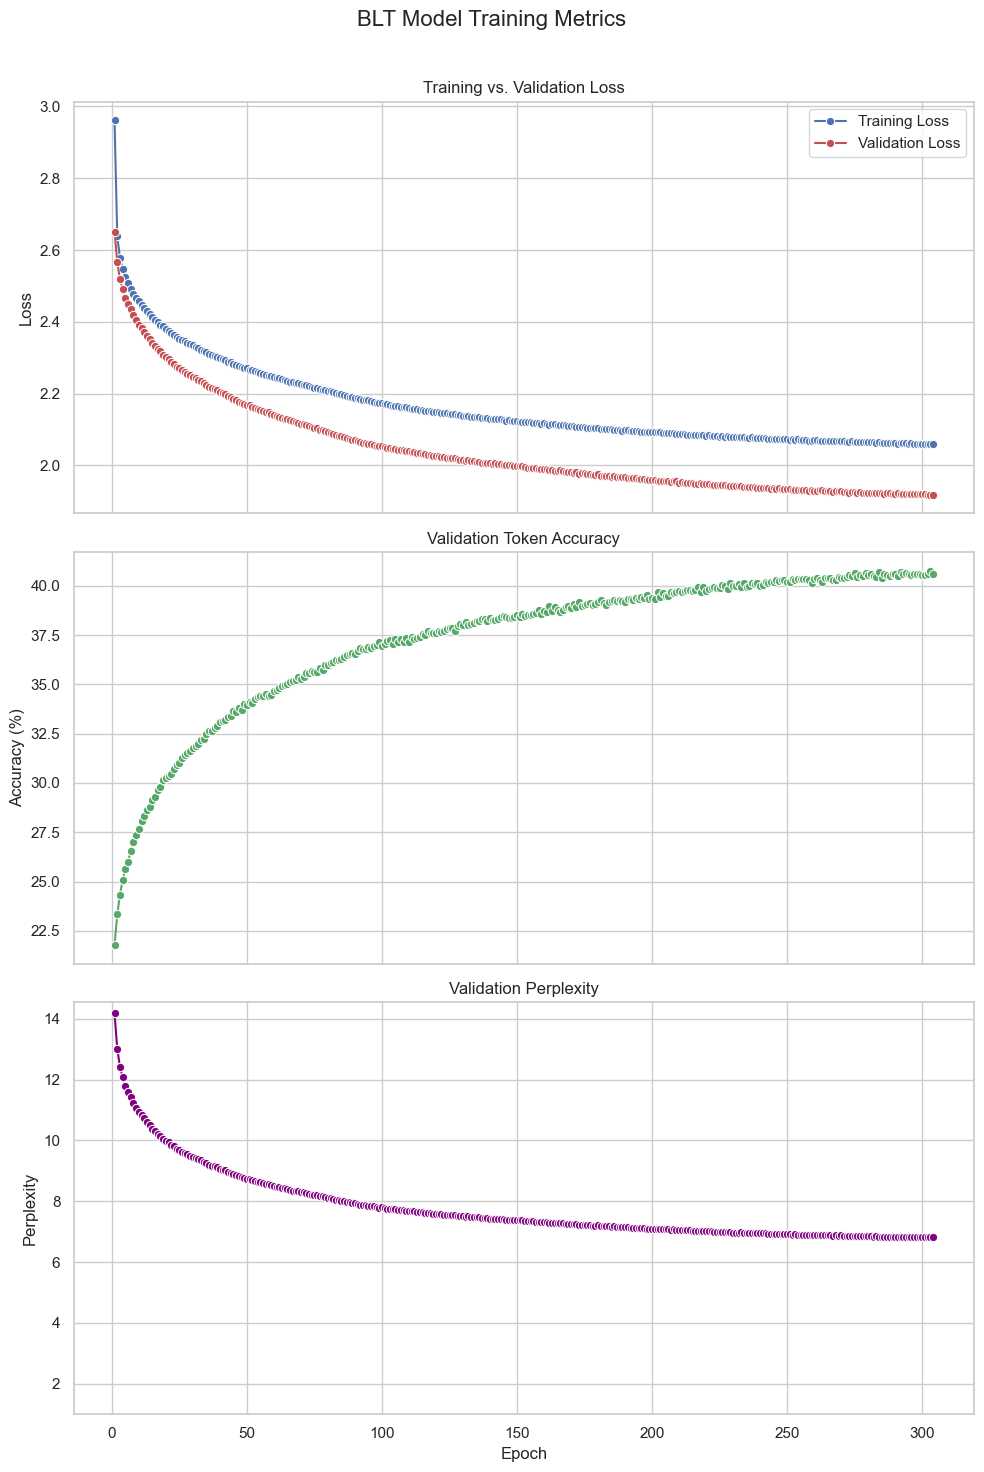

In [75]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- User Configuration ---
# Just change this to the name of your saved log file.
LOG_FILE_PATH = "training_log.txt"

def parse_log_file(file_path):
    """
    Reads the training log file and extracts metrics using regular expressions.
    This is extremely fast as it does not load any models.
    """
    metrics = []
    
    # Regex to find the lines with our metrics
    train_loss_regex = re.compile(r"Epoch (\d+)/\d+ - Train Loss: ([\d.]+)")
    val_metrics_regex = re.compile(r"Validation - Loss: ([\d.]+), Perplexity: ([\d.]+), Token Acc: ([\d.]+)%")

    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"ERROR: The log file was not found at '{file_path}'")
        print("Please save your training output to this file and try again.")
        return pd.DataFrame()

    epoch_data = {}
    for line in lines:
        train_match = train_loss_regex.search(line)
        val_match = val_metrics_regex.search(line)

        if train_match:
            # When we find a new training loss, we start a new record
            if epoch_data: # Save the previous epoch's complete data
                metrics.append(epoch_data)
            epoch_data = {
                "epoch": int(train_match.group(1)),
                "train_loss": float(train_match.group(2))
            }
        
        if val_match and epoch_data:
            # Add validation metrics to the current epoch's record
            epoch_data["val_loss"] = float(val_match.group(1))
            epoch_data["val_perplexity"] = float(val_match.group(2))
            epoch_data["val_accuracy"] = float(val_match.group(3))

    if epoch_data: # Append the last record
        metrics.append(epoch_data)
        
    return pd.DataFrame(metrics)

# --- Main Execution ---
if __name__ == '__main__':
    # 1. Parse the log file to get the metrics DataFrame
    metrics_df = parse_log_file(LOG_FILE_PATH)

    if metrics_df.empty:
        print("Could not extract any data. Please check the log file content and path.")
    else:
        print("--- Successfully Parsed Metrics ---")
        print(metrics_df.head())

        # 2. Plotting the results
        sns.set_theme(style="whitegrid")
        fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)
        fig.suptitle('BLT Model Training Metrics', fontsize=16)

        # Plot 1: Training vs. Validation Loss
        sns.lineplot(data=metrics_df, x='epoch', y='train_loss', ax=axes[0], label='Training Loss', color='b', marker='o')
        sns.lineplot(data=metrics_df, x='epoch', y='val_loss', ax=axes[0], label='Validation Loss', color='r', marker='o')
        axes[0].set_title('Training vs. Validation Loss')
        axes[0].set_ylabel('Loss')
        axes[0].legend()

        # Plot 2: Validation Token Accuracy
        sns.lineplot(data=metrics_df, x='epoch', y='val_accuracy', ax=axes[1], color='g', marker='o')
        axes[1].set_title('Validation Token Accuracy')
        axes[1].set_ylabel('Accuracy (%)')

        # Plot 3: Validation Perplexity
        sns.lineplot(data=metrics_df, x='epoch', y='val_perplexity', ax=axes[2], color='purple', marker='o')
        axes[2].set_title('Validation Perplexity')
        axes[2].set_ylabel('Perplexity')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylim(bottom=1) # Perplexity is meaningless below 1

        plt.tight_layout(rect=[0, 0, 1, 0.97])
        # Save the figure to a file
        plt.savefig("training_metrics_plot.png")
        print("\n✅ Graphs saved to 'training_metrics_plot.png'")
        plt.show()

## Inference Function (Text-to-Text Generation)

In [76]:
import torch
import torch.nn as nn

# --- Step 1: Define necessary components and vocabulary ---
# This should be consistent with your training script.

# Assume your helper functions (patchify) and model classes (BLTModel) are defined or imported.
# Assume your vocabulary constants are also defined. For clarity, here they are again:
PRINTABLE_ASCII = [chr(i) for i in range(32, 127)]
VOCAB = ['<PAD>', '<SOS>', '<EOS>'] + PRINTABLE_ASCII
CHAR_TO_IDX = {ch: i for i, ch in enumerate(VOCAB)}
IDX_TO_CHAR = {i: ch for i, ch in enumerate(VOCAB)}
PAD_IDX = CHAR_TO_IDX['<PAD>']
SOS_IDX = CHAR_TO_IDX['<SOS>']
EOS_IDX = CHAR_TO_IDX['<EOS>']


# --- Step 2: The Corrected Generation Function ---

@torch.no_grad()
def generate_prediction(model, input_text, max_len=100, device=None):
    """
    Generates a text-to-text prediction using the complete BLTModel.
    """
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    model.eval()
    model.to(device)

    # 1. Prepare the input: The model expects a BATCH of patch lists.
    #    For a single prediction, we create a batch of size 1.
    patches = patchify(input_text)
    src_patches_batch = [patches] # e.g., [['patch1', 'patch2']]

    # 2. Start the decoding process with the Start-Of-Sequence token.
    output_ids = [SOS_IDX]

    # 3. Autoregressively generate the output sequence one token at a time.
    for _ in range(max_len):
        # Prepare the current sequence as the decoder's input
        tgt_inp = torch.tensor([output_ids], dtype=torch.long, device=device)
        tgt_pad_mask = (tgt_inp == PAD_IDX)

        # >>> THE CRITICAL STEP <<<
        # Call the full model. It will handle the patch embedding, encoder,
        # global transformer, and decoder internally.
        logits = model(src_patches_batch, tgt_inp, tgt_pad_mask)
        
        # 4. Get the next token using greedy decoding (picking the most likely one).
        next_id = logits[:, -1, :].argmax().item()
        
        # 5. Append the new token and check if we should stop.
        output_ids.append(next_id)
        if next_id == EOS_IDX:
            break
            
    # 6. Convert the final list of token IDs back to a string.
    #    We skip the first token, which is the <SOS> token.
    output_text = "".join([IDX_TO_CHAR.get(i, "") for i in output_ids[1:] if i != EOS_IDX])
    
    return output_text


# --- Step 3: Example Usage ---

if __name__ == '__main__':
    # --- Load your final, trained model ---
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    # Instantiate the model with the correct vocab size
    model = BLTModel(vocab_size=len(VOCAB), d_model=64, nhead=4)
    
    # Load the checkpoint
    ckpt_path = "checkpoints/blt_epoch304.pt" # IMPORTANT: Use your final checkpoint
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")

    # --- Run Prediction ---
    input_text = "reconciliation trolls realized scene"
    output_text = generate_prediction(model, input_text, max_len=100, device=device)
    
    print("\n--- Inference Result ---")
    print(f"Input:  '{input_text}'")
    print(f"Output: '{output_text}'")
    print(f"Expected: '{input_text[::-1]}'")

✅ Loaded checkpoint from epoch 304


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



--- Inference Result ---
Input:  'reconciliation trolls realized scene'
Output: 'seillic detarts noitarep seillic noitaredni'
Expected: 'enecs dezilaer sllort noitailicnocer'


## Prediction on test data and saving CSV

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

# --- Step 1: Define ALL necessary components from your training script ---
# This makes the script runnable on its own.
# You MUST paste your final, corrected versions of the following:
#
# 1. All helper functions (patchify, etc.)
# 2. All vocabulary constants (VOCAB, CHAR_TO_IDX, IDX_TO_CHAR, PAD_IDX, SOS_IDX, EOS_IDX)
# 3. The BLTDataset class
# 4. The blt_collate_fn function
# 5. The PatchEmbedder, PositionalEncoding, and BLTModel classes

# --- Step 2: A Batch-Oriented Generation Function (Much Faster) ---

@torch.no_grad()
def generate_batch_predictions(model, data_loader, max_len=100, device=None):
    """
    Generates predictions for an entire DataLoader in batches for efficiency.
    """
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    model.eval()
    model.to(device)
    
    all_predictions = []
    progress_bar = tqdm(data_loader, desc="🚀 Generating Predictions")

    for src_patches_batch, _ in progress_bar:
        batch_size = len(src_patches_batch)
        
        # Start the decoding process for the whole batch with the SOS token
        output_ids = torch.full((batch_size, 1), SOS_IDX, dtype=torch.long, device=device)

        # A flag to track which sequences in the batch are finished
        finished = torch.zeros(batch_size, dtype=torch.bool, device=device)

        for _ in range(max_len):
            tgt_pad_mask = (output_ids == PAD_IDX)
            
            # Call the model once for the entire batch
            logits = model(src_patches_batch, output_ids, tgt_pad_mask)
            
            # Get the next token for every sequence in the batch
            next_ids = logits[:, -1, :].argmax(dim=-1).unsqueeze(1)
            
            # Append the new tokens to the sequences
            output_ids = torch.cat([output_ids, next_ids], dim=1)
            
            # Update the 'finished' status for any sequence that just generated an EOS token
            finished = finished | (next_ids.squeeze() == EOS_IDX)
            
            # If all sequences in the batch are finished, we can stop early
            if finished.all():
                break
        
        # Decode the generated ID sequences into text
        for i in range(batch_size):
            # Filter out special tokens
            filtered_ids = [idx for idx in output_ids[i].tolist() if idx not in {SOS_IDX, EOS_IDX, PAD_IDX}]
            pred_text = "".join([IDX_TO_CHAR.get(idx, "") for idx in filtered_ids])
            all_predictions.append(pred_text)
            
    return all_predictions

# --- Step 3: Main Execution Block ---

if __name__ == '__main__':
    # --- Configuration ---
    CHECKPOINT_PATH = "checkpoints/blt_epoch300.pt" # The final model to use
    BATCH_SIZE = 16 # Much faster than batch_size=1
    
    # Setup device
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    if device.type == "mps":
        torch.set_float32_matmul_precision("high")

    # --- Load Model ---
    model = BLTModel(vocab_size=len(VOCAB), d_model=64, nhead=4)
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")

    # --- Load Test Data ---
    test_df = pd.read_csv("./../data/test.csv")
    test_ds = BLTDataset(csv_path="./../data/test.csv")
    test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=blt_collate_fn
    )

    # --- Generate All Predictions ---
    predictions = generate_batch_predictions(model, test_loader, max_len=150, device=device)

    # --- Save Predictions in the Correct Format ---
    # As per the assignment, the output file should have 'input' and 'output' columns.
    output_df = pd.DataFrame({
        'input': test_df['input'],
        'output': predictions
    })
    
    os.makedirs("predictions", exist_ok=True)
    output_path = "predictions/predictions_BLT.csv"
    output_df.to_csv(output_path, index=False)
    
    print(f"\n✅ Predictions saved to {output_path}")
    print("\n--- Prediction Preview ---")
    print(output_df.head().to_string())

# Character level Model & Training

In [ ]:
import torch

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using MPS (Apple Silicon GPU)")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available, falling back to CPU")

✅ Using MPS (Apple Silicon GPU)


## Data & Tokenizer

1. Loads your train.csv and test.csv.
2. Creates a character vocabulary:
    - [PAD], [SOS], [EOS] + printable ASCII chars.
    - Maps chars ↔ IDs (stoi, itos).
3. Provides encode/decode functions.
4. Tests it on a sample string.

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import string

# --- Step 1: Load Data ---
train_df = pd.read_csv("./../data/train.csv")
test_df  = pd.read_csv("./../data/test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())

# --- Step 2: Character Tokenizer ---
# Printable ASCII characters 32–126
ascii_chars = [chr(i) for i in range(32, 127)]
special_tokens = ["[PAD]", "[SOS]", "[EOS]"]

itos = special_tokens + ascii_chars   # id → char
stoi = {ch: i for i, ch in enumerate(itos)}  # char → id

PAD_IDX = stoi["[PAD]"]
SOS_IDX = stoi["[SOS]"]
EOS_IDX = stoi["[EOS]"]

vocab_size = len(itos)

print("\nVocab size:", vocab_size)
print("PAD idx:", PAD_IDX, "SOS idx:", SOS_IDX, "EOS idx:", EOS_IDX)

# --- Encode / Decode functions ---
def encode_text(text, add_special=True):
    ids = [stoi[ch] for ch in text if ch in stoi]
    if add_special:
        ids = [SOS_IDX] + ids + [EOS_IDX]
    return torch.tensor(ids, dtype=torch.long)

def decode_ids(ids):
    chars = []
    for i in ids:
        if i == PAD_IDX or i == SOS_IDX or i == EOS_IDX:
            continue
        chars.append(itos[i])
    return "".join(chars)

# --- Quick test ---
sample = "LMA is fun!"
encoded = encode_text(sample)
decoded = decode_ids(encoded.tolist())

print("Sample:", sample)
print("Encoded:", encoded.tolist())
print("Decoded:", decoded)

Train shape: (10000, 2)
Test shape: (2000, 2)
                                               input  \
0               reconciliation trolls realized scene   
1                        scratched kemp blah devices   
2  delusional engineered perfect prey englishman ...   
3  boomers nfl reacts parallels everything 6 redu...   
4  patience put christmas superhero luc rake fulf...   

                                              target  
0               enecs dezilaer sllort noitailicnocer  
1                        secived halb pmek dehctarcs  
2  hctarcs detsub namhsilgne yerp tcefrep dereeni...  
3  stcudnoc ysereh redlof secuder 6 gnihtyreve sl...  
4  ylesned ylno elbats latnenitnoc dellifluf ekar...  

Vocab size: 98
PAD idx: 0 SOS idx: 1 EOS idx: 2
Sample: LMA is fun!
Encoded: [1, 47, 48, 36, 3, 76, 86, 3, 73, 88, 81, 4, 2]
Decoded: LMA is fun!


## Dataset + Collate

- CharDataset → loads strings, encodes them into token IDs.
- collate_fn → pads sequences per batch + stores lengths.
- DataLoader → provides batches for training & testing.
- Prints shapes and a decoded sample to check correctness.

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# --- Dataset Class ---
class CharDataset(Dataset):
    def __init__(self, df):
        self.inputs = df["input"].tolist()
        self.targets = df["target"].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        src_text = self.inputs[idx]
        tgt_text = self.targets[idx]

        src_ids = encode_text(src_text, add_special=True)  # [SOS] ... [EOS]
        tgt_ids = encode_text(tgt_text, add_special=True)

        return src_ids, tgt_ids


# --- Collate Function ---
def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)

    # Pad sequences
    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=PAD_IDX)
    tgt_padded = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_IDX)

    # Lengths (before padding)
    src_lengths = torch.tensor([len(x) for x in src_batch], dtype=torch.long)
    tgt_lengths = torch.tensor([len(x) for x in tgt_batch], dtype=torch.long)

    return src_padded, src_lengths, tgt_padded, tgt_lengths


# --- Create Dataset + DataLoader ---
train_ds = CharDataset(train_df)
test_ds = CharDataset(test_df)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

import pandas as pd
from sklearn.model_selection import train_test_split

test_df = pd.read_csv("./../data/test.csv")  # original test dataset
val_df, holdout_df = train_test_split(test_df, test_size=0.5, random_state=42)

val_ds = CharDataset(val_df)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)

# --- Quick Check ---
src_padded, src_lengths, tgt_padded, tgt_lengths = next(iter(train_loader))

print("src_padded shape:", src_padded.shape)
print("tgt_padded shape:", tgt_padded.shape)
print("\nsrc_lengths:", src_lengths[:5])
print("tgt_lengths:", tgt_lengths[:5])
print("\nExample decoded input:", decode_ids(src_padded[0].tolist()))
print("Example decoded target:", decode_ids(tgt_padded[0].tolist()))

src_padded shape: torch.Size([32, 132])
tgt_padded shape: torch.Size([32, 132])

src_lengths: tensor([67, 21, 80, 38, 67])
tgt_lengths: tensor([67, 21, 80, 38, 67])

Example decoded input: cam environments eventual fallen aug merchant garry quebec latter
Example decoded target: rettal cebeuq yrrag tnahcrem gua nellaf lautneve stnemnorivne mac


In [ ]:
# --- Character Vocabulary (printable ASCII + special tokens) ---
import string

PAD_IDX = 0
SOS_IDX = 1
EOS_IDX = 2

# Printable ASCII characters (32-126)
chars = [chr(i) for i in range(32, 127)]
VOCAB = {c: i+3 for i, c in enumerate(chars)}  # reserve 0,1,2 for PAD, SOS, EOS
INV_VOCAB = {i: c for c, i in VOCAB.items()}

VOCAB_SIZE = len(VOCAB) + 3  # include PAD, SOS, EOS
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 98


## Baseline Model

- Embedding layer for characters
- Positional encoding
- Transformer encoder–decoder (2 layers each)
- Linear projection to vocab size

In [ ]:
import math
import torch
import torch.nn as nn

# --- Positional Encoding (sinusoidal) ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [B, L, D]
        x = x + self.pe[:, :x.size(1), :]
        return x


# --- Baseline Transformer Model ---
class CharTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=64, nhead=4, num_layers=2, dim_ff=128, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        # Embeddings
        self.src_embed = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)
        self.tgt_embed = nn.Embedding(vocab_size, d_model, padding_idx=PAD_IDX)

        self.pos_encoder = PositionalEncoding(d_model)

        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead,
                                                    dim_feedforward=dim_ff, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, enable_nested_tensor=False)

        # Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead,
                                                    dim_feedforward=dim_ff, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        # Output projection
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt_inp):
        """
        src: [B, Ls]
        tgt_inp: [B, Lt]
        """
        # Embedding + positional encoding
        src_emb = self.pos_encoder(self.src_embed(src))  # [B, Ls, D]
        tgt_emb = self.pos_encoder(self.tgt_embed(tgt_inp))  # [B, Lt, D]

        # Masks
        src_key_padding_mask = (src == PAD_IDX)  # [B, Ls]
        tgt_key_padding_mask = (tgt_inp == PAD_IDX)  # [B, Lt]
        causal_mask = nn.Transformer.generate_square_subsequent_mask(tgt_inp.size(1)).to(src.device)

        # Encode
        memory = self.encoder(src_emb, src_key_padding_mask=src_key_padding_mask)

        # Decode
        out = self.decoder(tgt=tgt_emb, memory=memory,
                            tgt_mask=causal_mask,
                            tgt_key_padding_mask=tgt_key_padding_mask,
                            memory_key_padding_mask=src_key_padding_mask)

        # Project to vocab
        logits = self.fc_out(out)  # [B, Lt, vocab_size]
        return logits

In [ ]:
# Create model
baseline_model = CharTransformer(vocab_size=len(VOCAB), d_model=64, nhead=4, num_layers=2).to(device)

# Dummy batch
src_padded, src_lengths, tgt_padded, tgt_lengths = next(iter(train_loader))

# Teacher forcing: shift target
tgt_inp = tgt_padded[:, :-1]
tgt_out = tgt_padded[:, 1:]

# Forward pass
logits = baseline_model(src_padded.to(device), tgt_inp.to(device))

print("Logits shape:", logits.shape)  # [B, Lt-1, vocab_size]

Logits shape: torch.Size([32, 117, 95])


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


## Training

- AdamW optimizer
- CrossEntropyLoss with ignore_index=PAD_IDX
- Gradient clipping
- Checkpoint saving every few epochs
- Optional resume from checkpoint

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.nn.utils import clip_grad_norm_

# ----------------------------
# Training loop for baseline Transformer
# ----------------------------
def train_baseline(
    model,
    train_loader,
    val_loader=None,   # optional validation loader
    num_epochs=1000,
    lr=1e-3,
    device=None,
    save_every=5,
    val_every=50,
    resume_path=None
):
    # --- Pick device automatically if not provided ---
    if device is None:
        if torch.backends.mps.is_available():
            device = torch.device("mps")
        elif torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
    print(f"Training on: {device}")

    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)  # ignore <PAD> tokens

    os.makedirs("checkpoints_baseline", exist_ok=True)

    # --- Resume from checkpoint ---
    start_epoch = 1
    if resume_path and os.path.exists(resume_path):
        print(f"🔄 Resuming from checkpoint: {resume_path}")
        checkpoint = torch.load(resume_path, map_location=device)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        start_epoch = checkpoint["epoch"] + 1
        print(f"✅ Resumed from epoch {checkpoint['epoch']} (loss {checkpoint['loss']:.4f})")

    # --- Training loop ---
    for epoch in range(start_epoch, num_epochs + 1):
        model.train()
        total_loss = 0.0

        for batch in train_loader:
            src, src_lengths, tgt, tgt_lengths = batch
            src, tgt = src.to(device), tgt.to(device)

            tgt_inp = tgt[:, :-1]   # decoder input
            tgt_out = tgt[:, 1:]    # expected output

            logits = model(src, tgt_inp)

            loss = criterion(
                logits.reshape(-1, logits.size(-1)),
                tgt_out.reshape(-1)
            )

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        
        # --- Validation ---
        if val_loader is not None:
            val_loss, val_acc = evaluate_baseline(model, val_loader, criterion, device)
            val_perplexity = math.exp(val_loss)
            print(f"📘 Epoch {epoch}/{num_epochs} - Train Loss: {avg_loss:.4f}")
            print(f"📗 Validation - Loss: {val_loss:.4f}, Perplexity: {val_perplexity:.2f}, Token Acc: {val_acc:.2f}%")
        else:
            print(f"📘 Epoch {epoch}/{num_epochs} - Train Loss: {avg_loss:.4f}")

        # --- Save checkpoint ---
        if epoch % save_every == 0 or epoch == num_epochs:
            ckpt_path = f"checkpoints_baseline/char_transformer_epoch{epoch}.pt"
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "loss": avg_loss
            }, ckpt_path)
            print(f"✅ Saved checkpoint: {ckpt_path}")


# ----------------------------
# Evaluation / Validation
# ----------------------------
@torch.no_grad()
def evaluate_baseline(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_tokens = 0
    correct_tokens = 0

    for batch in val_loader:
        src, src_lengths, tgt, tgt_lengths = batch
        src, tgt = src.to(device), tgt.to(device)

        tgt_inp = tgt[:, :-1]
        tgt_out = tgt[:, 1:]

        logits = model(src, tgt_inp)

        # Compute loss
        loss = criterion(
            logits.reshape(-1, logits.size(-1)),
            tgt_out.reshape(-1)
        )
        total_loss += loss.item()

        # Accuracy (ignore PAD)
        preds = logits.argmax(dim=-1)
        mask = tgt_out != PAD_IDX
        correct_tokens += ((preds == tgt_out) & mask).sum().item()
        total_tokens += mask.sum().item()

    avg_loss = total_loss / len(val_loader)
    accuracy = 100.0 * correct_tokens / total_tokens
    return avg_loss, accuracy

In [ ]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

device = torch.device("mps")
train_baseline(
    model=baseline_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=1000,
    lr=1e-3,
    device=device,
    save_every=10,
    resume_path="checkpoints_baseline/char_transformer_epoch500.pt"
)

Training on: mps
🔄 Resuming from checkpoint: checkpoints_baseline/char_transformer_epoch470.pt
✅ Resumed from epoch 470 (loss 0.0057)
📘 Epoch 471/1000 - Train Loss: 0.0056
📗 Validation - Loss: 0.0004, Perplexity: 1.00, Token Acc: 99.96%
📘 Epoch 472/1000 - Train Loss: 0.0062
📗 Validation - Loss: 0.0004, Perplexity: 1.00, Token Acc: 99.95%
📘 Epoch 473/1000 - Train Loss: 0.0062
📗 Validation - Loss: 0.0006, Perplexity: 1.00, Token Acc: 99.95%
📘 Epoch 474/1000 - Train Loss: 0.0061
📗 Validation - Loss: 0.0003, Perplexity: 1.00, Token Acc: 99.96%
📘 Epoch 475/1000 - Train Loss: 0.0061
📗 Validation - Loss: 0.0005, Perplexity: 1.00, Token Acc: 99.96%
📘 Epoch 476/1000 - Train Loss: 0.0054
📗 Validation - Loss: 0.0002, Perplexity: 1.00, Token Acc: 99.96%
📘 Epoch 477/1000 - Train Loss: 0.0056
📗 Validation - Loss: 0.0004, Perplexity: 1.00, Token Acc: 99.96%
📘 Epoch 478/1000 - Train Loss: 0.0063
📗 Validation - Loss: 0.0011, Perplexity: 1.00, Token Acc: 99.94%
📘 Epoch 479/1000 - Train Loss: 0.0063
📗 Va

KeyboardInterrupt: 

#### Output

Training on: mps
🔄 Resuming from checkpoint: checkpoints_baseline/char_transformer_epoch50.pt
✅ Resumed from epoch 50 (loss 0.2597)
📘 Epoch 51/1000 - Train Loss: 0.2541
📘 Epoch 52/1000 - Train Loss: 0.2507
📘 Epoch 53/1000 - Train Loss: 0.2461
📘 Epoch 54/1000 - Train Loss: 0.2391
📘 Epoch 55/1000 - Train Loss: 0.2377
📘 Epoch 56/1000 - Train Loss: 0.2259
📘 Epoch 57/1000 - Train Loss: 0.2206
📘 Epoch 58/1000 - Train Loss: 0.2184
📘 Epoch 59/1000 - Train Loss: 0.2203
📘 Epoch 60/1000 - Train Loss: 0.2083
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch60.pt
📘 Epoch 61/1000 - Train Loss: 0.2050
📘 Epoch 62/1000 - Train Loss: 0.2049
📘 Epoch 63/1000 - Train Loss: 0.1927
📘 Epoch 64/1000 - Train Loss: 0.1986
📘 Epoch 65/1000 - Train Loss: 0.1843
📘 Epoch 66/1000 - Train Loss: 0.1815
📘 Epoch 67/1000 - Train Loss: 0.1738
📘 Epoch 68/1000 - Train Loss: 0.1757
📘 Epoch 69/1000 - Train Loss: 0.1659
📘 Epoch 70/1000 - Train Loss: 0.1662
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch70.pt
📘 Epoch 71/1000 - Train Loss: 0.1609
📘 Epoch 72/1000 - Train Loss: 0.1558
📘 Epoch 73/1000 - Train Loss: 0.1553
📘 Epoch 74/1000 - Train Loss: 0.1495
📘 Epoch 75/1000 - Train Loss: 0.1385
📘 Epoch 76/1000 - Train Loss: 0.1384
📘 Epoch 77/1000 - Train Loss: 0.1372
📘 Epoch 78/1000 - Train Loss: 0.1381
📘 Epoch 79/1000 - Train Loss: 0.1260
📘 Epoch 80/1000 - Train Loss: 0.1224
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch80.pt
📘 Epoch 81/1000 - Train Loss: 0.1169
📘 Epoch 82/1000 - Train Loss: 0.1102
📘 Epoch 83/1000 - Train Loss: 0.1037
📘 Epoch 84/1000 - Train Loss: 0.0933
📘 Epoch 85/1000 - Train Loss: 0.0786
📘 Epoch 86/1000 - Train Loss: 0.0637
📘 Epoch 87/1000 - Train Loss: 0.0627
📘 Epoch 88/1000 - Train Loss: 0.0563
📘 Epoch 89/1000 - Train Loss: 0.0493
📘 Epoch 90/1000 - Train Loss: 0.0476
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch90.pt
📘 Epoch 91/1000 - Train Loss: 0.0438
📘 Epoch 92/1000 - Train Loss: 0.0410
📘 Epoch 93/1000 - Train Loss: 0.0381
📘 Epoch 94/1000 - Train Loss: 0.0376
📘 Epoch 95/1000 - Train Loss: 0.0350
📘 Epoch 96/1000 - Train Loss: 0.0354
📘 Epoch 97/1000 - Train Loss: 0.0362
📘 Epoch 98/1000 - Train Loss: 0.0319
📘 Epoch 99/1000 - Train Loss: 0.0318
📘 Epoch 100/1000 - Train Loss: 0.0310
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch100.pt
📘 Epoch 101/1000 - Train Loss: 0.0312
📘 Epoch 102/1000 - Train Loss: 0.0310
📘 Epoch 103/1000 - Train Loss: 0.0307
📘 Epoch 104/1000 - Train Loss: 0.0289
📘 Epoch 105/1000 - Train Loss: 0.0290
📘 Epoch 106/1000 - Train Loss: 0.0297
📘 Epoch 107/1000 - Train Loss: 0.0274
📘 Epoch 108/1000 - Train Loss: 0.0282
📘 Epoch 109/1000 - Train Loss: 0.0267
📘 Epoch 110/1000 - Train Loss: 0.0272
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch110.pt
📘 Epoch 111/1000 - Train Loss: 0.0267
📘 Epoch 112/1000 - Train Loss: 0.0264
📘 Epoch 113/1000 - Train Loss: 0.0253
📘 Epoch 114/1000 - Train Loss: 0.0256
📘 Epoch 115/1000 - Train Loss: 0.0245
📘 Epoch 116/1000 - Train Loss: 0.0250
📘 Epoch 117/1000 - Train Loss: 0.0255
📘 Epoch 118/1000 - Train Loss: 0.0250
📘 Epoch 119/1000 - Train Loss: 0.0243
📘 Epoch 120/1000 - Train Loss: 0.0230
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch120.pt
📘 Epoch 121/1000 - Train Loss: 0.0239
📘 Epoch 122/1000 - Train Loss: 0.0231
📘 Epoch 123/1000 - Train Loss: 0.0225
📘 Epoch 124/1000 - Train Loss: 0.0240
📘 Epoch 125/1000 - Train Loss: 0.0229
📘 Epoch 126/1000 - Train Loss: 0.0230
📘 Epoch 127/1000 - Train Loss: 0.0211
📘 Epoch 128/1000 - Train Loss: 0.0224
📘 Epoch 129/1000 - Train Loss: 0.0209
📘 Epoch 130/1000 - Train Loss: 0.0223
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch130.pt
📘 Epoch 131/1000 - Train Loss: 0.0201
📘 Epoch 132/1000 - Train Loss: 0.0226
📘 Epoch 133/1000 - Train Loss: 0.0220
📘 Epoch 134/1000 - Train Loss: 0.0210
📘 Epoch 135/1000 - Train Loss: 0.0196
📘 Epoch 136/1000 - Train Loss: 0.0196
📘 Epoch 137/1000 - Train Loss: 0.0206
📘 Epoch 138/1000 - Train Loss: 0.0202
📘 Epoch 139/1000 - Train Loss: 0.0196
📘 Epoch 140/1000 - Train Loss: 0.0183
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch140.pt
📘 Epoch 141/1000 - Train Loss: 0.0211
📘 Epoch 142/1000 - Train Loss: 0.0195
📘 Epoch 143/1000 - Train Loss: 0.0204
📘 Epoch 144/1000 - Train Loss: 0.0193
📘 Epoch 145/1000 - Train Loss: 0.0197
📘 Epoch 146/1000 - Train Loss: 0.0180
📘 Epoch 147/1000 - Train Loss: 0.0195
📘 Epoch 148/1000 - Train Loss: 0.0204
📘 Epoch 149/1000 - Train Loss: 0.0177
📘 Epoch 150/1000 - Train Loss: 0.0187
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch150.pt
📘 Epoch 151/1000 - Train Loss: 0.0198
📘 Epoch 152/1000 - Train Loss: 0.0182
📘 Epoch 153/1000 - Train Loss: 0.0183
📘 Epoch 154/1000 - Train Loss: 0.0178
📘 Epoch 155/1000 - Train Loss: 0.0183
📘 Epoch 156/1000 - Train Loss: 0.0183
📘 Epoch 157/1000 - Train Loss: 0.0181
📘 Epoch 158/1000 - Train Loss: 0.0160
📘 Epoch 159/1000 - Train Loss: 0.0184
📘 Epoch 160/1000 - Train Loss: 0.0172
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch160.pt
📘 Epoch 161/1000 - Train Loss: 0.0181
📘 Epoch 162/1000 - Train Loss: 0.0177
📘 Epoch 163/1000 - Train Loss: 0.0169
📘 Epoch 164/1000 - Train Loss: 0.0184
📘 Epoch 165/1000 - Train Loss: 0.0167
📘 Epoch 166/1000 - Train Loss: 0.0191
📘 Epoch 167/1000 - Train Loss: 0.0171
📘 Epoch 168/1000 - Train Loss: 0.0172
📘 Epoch 169/1000 - Train Loss: 0.0172
📘 Epoch 170/1000 - Train Loss: 0.0171
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch170.pt
📘 Epoch 171/1000 - Train Loss: 0.0156
📘 Epoch 172/1000 - Train Loss: 0.0165
📘 Epoch 173/1000 - Train Loss: 0.0161
📘 Epoch 174/1000 - Train Loss: 0.0177
📘 Epoch 175/1000 - Train Loss: 0.0161
📘 Epoch 176/1000 - Train Loss: 0.0166
📘 Epoch 177/1000 - Train Loss: 0.0164
📘 Epoch 178/1000 - Train Loss: 0.0157
📘 Epoch 179/1000 - Train Loss: 0.0151
📘 Epoch 180/1000 - Train Loss: 0.0152
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch180.pt
📘 Epoch 181/1000 - Train Loss: 0.0155
📘 Epoch 182/1000 - Train Loss: 0.0168
📘 Epoch 183/1000 - Train Loss: 0.0158
📘 Epoch 184/1000 - Train Loss: 0.0158
📘 Epoch 185/1000 - Train Loss: 0.0163
📘 Epoch 186/1000 - Train Loss: 0.0145
📘 Epoch 187/1000 - Train Loss: 0.0160
📘 Epoch 188/1000 - Train Loss: 0.0145
📘 Epoch 189/1000 - Train Loss: 0.0149
📘 Epoch 190/1000 - Train Loss: 0.0144
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch190.pt
📘 Epoch 191/1000 - Train Loss: 0.0158
📘 Epoch 192/1000 - Train Loss: 0.0151
📘 Epoch 193/1000 - Train Loss: 0.0147
📘 Epoch 194/1000 - Train Loss: 0.0142
📘 Epoch 195/1000 - Train Loss: 0.0154
📘 Epoch 196/1000 - Train Loss: 0.0146
📘 Epoch 197/1000 - Train Loss: 0.0147
📘 Epoch 198/1000 - Train Loss: 0.0143
📘 Epoch 199/1000 - Train Loss: 0.0150
📘 Epoch 200/1000 - Train Loss: 0.0149
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch200.pt
📘 Epoch 201/1000 - Train Loss: 0.0134
📘 Epoch 202/1000 - Train Loss: 0.0154
📘 Epoch 203/1000 - Train Loss: 0.0137
📘 Epoch 204/1000 - Train Loss: 0.0142
📘 Epoch 205/1000 - Train Loss: 0.0142
📘 Epoch 206/1000 - Train Loss: 0.0140
📘 Epoch 207/1000 - Train Loss: 0.0142
📘 Epoch 208/1000 - Train Loss: 0.0136
📘 Epoch 209/1000 - Train Loss: 0.0145
📘 Epoch 210/1000 - Train Loss: 0.0128
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch210.pt
📘 Epoch 211/1000 - Train Loss: 0.0138
📘 Epoch 212/1000 - Train Loss: 0.0138
📘 Epoch 213/1000 - Train Loss: 0.0129
📘 Epoch 214/1000 - Train Loss: 0.0141
📘 Epoch 215/1000 - Train Loss: 0.0127
📘 Epoch 216/1000 - Train Loss: 0.0136
📘 Epoch 217/1000 - Train Loss: 0.0143
📘 Epoch 218/1000 - Train Loss: 0.0127
📘 Epoch 219/1000 - Train Loss: 0.0141
📘 Epoch 220/1000 - Train Loss: 0.0149
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch220.pt
📘 Epoch 221/1000 - Train Loss: 0.0127
📘 Epoch 222/1000 - Train Loss: 0.0130
📘 Epoch 223/1000 - Train Loss: 0.0122
📘 Epoch 224/1000 - Train Loss: 0.0140
📘 Epoch 225/1000 - Train Loss: 0.0117
📘 Epoch 226/1000 - Train Loss: 0.0124
📘 Epoch 227/1000 - Train Loss: 0.0139
📘 Epoch 228/1000 - Train Loss: 0.0126
📘 Epoch 229/1000 - Train Loss: 0.0134
📘 Epoch 230/1000 - Train Loss: 0.0134
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch230.pt
📘 Epoch 231/1000 - Train Loss: 0.0138
📘 Epoch 232/1000 - Train Loss: 0.0117
📘 Epoch 233/1000 - Train Loss: 0.0124
📘 Epoch 234/1000 - Train Loss: 0.0126
📘 Epoch 235/1000 - Train Loss: 0.0112
📘 Epoch 236/1000 - Train Loss: 0.0125
📘 Epoch 237/1000 - Train Loss: 0.0125
📘 Epoch 238/1000 - Train Loss: 0.0129
📘 Epoch 239/1000 - Train Loss: 0.0117
📘 Epoch 240/1000 - Train Loss: 0.0130
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch240.pt
📘 Epoch 241/1000 - Train Loss: 0.0122
📘 Epoch 242/1000 - Train Loss: 0.0117
📘 Epoch 243/1000 - Train Loss: 0.0118
📘 Epoch 244/1000 - Train Loss: 0.0116
📘 Epoch 245/1000 - Train Loss: 0.0131
📘 Epoch 246/1000 - Train Loss: 0.0126
📘 Epoch 247/1000 - Train Loss: 0.0114
📘 Epoch 248/1000 - Train Loss: 0.0113
📘 Epoch 249/1000 - Train Loss: 0.0113
📘 Epoch 250/1000 - Train Loss: 0.0119
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch250.pt
📘 Epoch 251/1000 - Train Loss: 0.0117
📘 Epoch 252/1000 - Train Loss: 0.0114
📘 Epoch 253/1000 - Train Loss: 0.0111
📘 Epoch 254/1000 - Train Loss: 0.0111
📘 Epoch 255/1000 - Train Loss: 0.0118
📘 Epoch 256/1000 - Train Loss: 0.0119
📘 Epoch 257/1000 - Train Loss: 0.0118
📘 Epoch 258/1000 - Train Loss: 0.0106
📘 Epoch 259/1000 - Train Loss: 0.0119
📘 Epoch 260/1000 - Train Loss: 0.0110
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch260.pt
📘 Epoch 261/1000 - Train Loss: 0.0111
📘 Epoch 262/1000 - Train Loss: 0.0110
📘 Epoch 263/1000 - Train Loss: 0.0113
📘 Epoch 264/1000 - Train Loss: 0.0107
📘 Epoch 265/1000 - Train Loss: 0.0104
📘 Epoch 266/1000 - Train Loss: 0.0115
📘 Epoch 267/1000 - Train Loss: 0.0114
📘 Epoch 268/1000 - Train Loss: 0.0111
📘 Epoch 269/1000 - Train Loss: 0.0113
📘 Epoch 270/1000 - Train Loss: 0.0111
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch270.pt
📘 Epoch 271/1000 - Train Loss: 0.0105
📘 Epoch 272/1000 - Train Loss: 0.0101
📘 Epoch 273/1000 - Train Loss: 0.0104
📘 Epoch 274/1000 - Train Loss: 0.0111
📘 Epoch 275/1000 - Train Loss: 0.0104
📘 Epoch 276/1000 - Train Loss: 0.0099
📘 Epoch 277/1000 - Train Loss: 0.0099
📘 Epoch 278/1000 - Train Loss: 0.0106
📘 Epoch 279/1000 - Train Loss: 0.0103
📘 Epoch 280/1000 - Train Loss: 0.0110
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch280.pt
📘 Epoch 281/1000 - Train Loss: 0.0113
📘 Epoch 282/1000 - Train Loss: 0.0104
📘 Epoch 283/1000 - Train Loss: 0.0107
📘 Epoch 284/1000 - Train Loss: 0.0103
📘 Epoch 285/1000 - Train Loss: 0.0102
📘 Epoch 286/1000 - Train Loss: 0.0115
📘 Epoch 287/1000 - Train Loss: 0.0104
📘 Epoch 288/1000 - Train Loss: 0.0101
📘 Epoch 289/1000 - Train Loss: 0.0098
📘 Epoch 290/1000 - Train Loss: 0.0098
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch290.pt
📘 Epoch 291/1000 - Train Loss: 0.0109
📘 Epoch 292/1000 - Train Loss: 0.0096
📘 Epoch 293/1000 - Train Loss: 0.0111
📘 Epoch 294/1000 - Train Loss: 0.0100
📘 Epoch 295/1000 - Train Loss: 0.0101
📘 Epoch 296/1000 - Train Loss: 0.0105
📘 Epoch 297/1000 - Train Loss: 0.0097
📘 Epoch 298/1000 - Train Loss: 0.0106
📘 Epoch 299/1000 - Train Loss: 0.0103
📘 Epoch 300/1000 - Train Loss: 0.0095
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch300.pt
📘 Epoch 301/1000 - Train Loss: 0.0092
📘 Epoch 302/1000 - Train Loss: 0.0096
📘 Epoch 303/1000 - Train Loss: 0.0107
📘 Epoch 304/1000 - Train Loss: 0.0097
📘 Epoch 305/1000 - Train Loss: 0.0096
📘 Epoch 306/1000 - Train Loss: 0.0102
📘 Epoch 307/1000 - Train Loss: 0.0101
📘 Epoch 308/1000 - Train Loss: 0.0095
📘 Epoch 309/1000 - Train Loss: 0.0106
📘 Epoch 310/1000 - Train Loss: 0.0098
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch310.pt
📘 Epoch 311/1000 - Train Loss: 0.0088
📘 Epoch 312/1000 - Train Loss: 0.0098
📘 Epoch 313/1000 - Train Loss: 0.0093
📘 Epoch 314/1000 - Train Loss: 0.0101
📘 Epoch 315/1000 - Train Loss: 0.0096
📘 Epoch 316/1000 - Train Loss: 0.0087
📘 Epoch 317/1000 - Train Loss: 0.0093
📘 Epoch 318/1000 - Train Loss: 0.0098
📘 Epoch 319/1000 - Train Loss: 0.0088
📘 Epoch 320/1000 - Train Loss: 0.0095
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch320.pt
📘 Epoch 321/1000 - Train Loss: 0.0090
📘 Epoch 322/1000 - Train Loss: 0.0092
📘 Epoch 323/1000 - Train Loss: 0.0096
📘 Epoch 324/1000 - Train Loss: 0.0089
📘 Epoch 325/1000 - Train Loss: 0.0093
📘 Epoch 326/1000 - Train Loss: 0.0106
📘 Epoch 327/1000 - Train Loss: 0.0091
📘 Epoch 328/1000 - Train Loss: 0.0086
📘 Epoch 329/1000 - Train Loss: 0.0102
📘 Epoch 330/1000 - Train Loss: 0.0089
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch330.pt
📘 Epoch 331/1000 - Train Loss: 0.0093
📘 Epoch 332/1000 - Train Loss: 0.0091
📘 Epoch 333/1000 - Train Loss: 0.0086
📘 Epoch 334/1000 - Train Loss: 0.0087
📘 Epoch 335/1000 - Train Loss: 0.0087
📘 Epoch 336/1000 - Train Loss: 0.0091
📘 Epoch 337/1000 - Train Loss: 0.0095
📘 Epoch 338/1000 - Train Loss: 0.0095
📘 Epoch 339/1000 - Train Loss: 0.0089
📘 Epoch 340/1000 - Train Loss: 0.0091
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch340.pt
📘 Epoch 341/1000 - Train Loss: 0.0085
📘 Epoch 342/1000 - Train Loss: 0.0089
📘 Epoch 343/1000 - Train Loss: 0.0093
📘 Epoch 344/1000 - Train Loss: 0.0083
📘 Epoch 345/1000 - Train Loss: 0.0090
📘 Epoch 346/1000 - Train Loss: 0.0086
📘 Epoch 347/1000 - Train Loss: 0.0086
📘 Epoch 348/1000 - Train Loss: 0.0091
📘 Epoch 349/1000 - Train Loss: 0.0089
📘 Epoch 350/1000 - Train Loss: 0.0090
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch350.pt
📘 Epoch 351/1000 - Train Loss: 0.0088
📘 Epoch 352/1000 - Train Loss: 0.0086
📘 Epoch 353/1000 - Train Loss: 0.0082
📘 Epoch 354/1000 - Train Loss: 0.0098
📘 Epoch 355/1000 - Train Loss: 0.0082
📘 Epoch 356/1000 - Train Loss: 0.0094
📘 Epoch 357/1000 - Train Loss: 0.0085
📘 Epoch 358/1000 - Train Loss: 0.0088
📘 Epoch 359/1000 - Train Loss: 0.0085
📘 Epoch 360/1000 - Train Loss: 0.0080
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch360.pt
📘 Epoch 361/1000 - Train Loss: 0.0097
📘 Epoch 362/1000 - Train Loss: 0.0082
📘 Epoch 363/1000 - Train Loss: 0.0084
📘 Epoch 364/1000 - Train Loss: 0.0091
📘 Epoch 365/1000 - Train Loss: 0.0082
📘 Epoch 366/1000 - Train Loss: 0.0088
📘 Epoch 367/1000 - Train Loss: 0.0082
📘 Epoch 368/1000 - Train Loss: 0.0078
📘 Epoch 369/1000 - Train Loss: 0.0084
📘 Epoch 370/1000 - Train Loss: 0.0089
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch370.pt
📘 Epoch 371/1000 - Train Loss: 0.0080
📘 Epoch 372/1000 - Train Loss: 0.0091
📘 Epoch 373/1000 - Train Loss: 0.0088
📘 Epoch 374/1000 - Train Loss: 0.0084
📘 Epoch 375/1000 - Train Loss: 0.0079
📘 Epoch 376/1000 - Train Loss: 0.0086
📘 Epoch 377/1000 - Train Loss: 0.0076
📘 Epoch 378/1000 - Train Loss: 0.0080
📘 Epoch 379/1000 - Train Loss: 0.0086
📘 Epoch 380/1000 - Train Loss: 0.0074
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch380.pt
📘 Epoch 381/1000 - Train Loss: 0.0078
📘 Epoch 382/1000 - Train Loss: 0.0086
📘 Epoch 383/1000 - Train Loss: 0.0083
📘 Epoch 384/1000 - Train Loss: 0.0079
📘 Epoch 385/1000 - Train Loss: 0.0078
📘 Epoch 386/1000 - Train Loss: 0.0080
📘 Epoch 387/1000 - Train Loss: 0.0078
📘 Epoch 388/1000 - Train Loss: 0.0076
📘 Epoch 389/1000 - Train Loss: 0.0081
📘 Epoch 390/1000 - Train Loss: 0.0084
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch390.pt
📘 Epoch 391/1000 - Train Loss: 0.0081
📘 Epoch 392/1000 - Train Loss: 0.0085
📘 Epoch 393/1000 - Train Loss: 0.0079
📘 Epoch 394/1000 - Train Loss: 0.0078
📘 Epoch 395/1000 - Train Loss: 0.0074
📘 Epoch 396/1000 - Train Loss: 0.0079
📘 Epoch 397/1000 - Train Loss: 0.0074
📘 Epoch 398/1000 - Train Loss: 0.0078
📘 Epoch 399/1000 - Train Loss: 0.0071
📘 Epoch 400/1000 - Train Loss: 0.0074
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch400.pt
📘 Epoch 401/1000 - Train Loss: 0.0073
📘 Epoch 402/1000 - Train Loss: 0.0078
📘 Epoch 403/1000 - Train Loss: 0.0064
📘 Epoch 404/1000 - Train Loss: 0.0070
📘 Epoch 405/1000 - Train Loss: 0.0081
📘 Epoch 406/1000 - Train Loss: 0.0078
📘 Epoch 407/1000 - Train Loss: 0.0077
📘 Epoch 408/1000 - Train Loss: 0.0075
📘 Epoch 409/1000 - Train Loss: 0.0074
📘 Epoch 410/1000 - Train Loss: 0.0071
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch410.pt
📘 Epoch 411/1000 - Train Loss: 0.0071
📘 Epoch 412/1000 - Train Loss: 0.0073
📘 Epoch 413/1000 - Train Loss: 0.0079
📘 Epoch 414/1000 - Train Loss: 0.0074
📘 Epoch 415/1000 - Train Loss: 0.0063
📘 Epoch 416/1000 - Train Loss: 0.0080
📘 Epoch 417/1000 - Train Loss: 0.0066
📘 Epoch 418/1000 - Train Loss: 0.0072
📘 Epoch 419/1000 - Train Loss: 0.0069
📘 Epoch 420/1000 - Train Loss: 0.0072
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch420.pt
📘 Epoch 421/1000 - Train Loss: 0.0072
📘 Epoch 422/1000 - Train Loss: 0.0069
📘 Epoch 423/1000 - Train Loss: 0.0069
📘 Epoch 424/1000 - Train Loss: 0.0067
📘 Epoch 425/1000 - Train Loss: 0.0068
📘 Epoch 426/1000 - Train Loss: 0.0069
📘 Epoch 427/1000 - Train Loss: 0.0068
📘 Epoch 428/1000 - Train Loss: 0.0067
📘 Epoch 429/1000 - Train Loss: 0.0071
📘 Epoch 430/1000 - Train Loss: 0.0068
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch430.pt
📘 Epoch 431/1000 - Train Loss: 0.0066
📘 Epoch 432/1000 - Train Loss: 0.0069
📘 Epoch 433/1000 - Train Loss: 0.0064
📘 Epoch 434/1000 - Train Loss: 0.0065
📘 Epoch 435/1000 - Train Loss: 0.0067
📘 Epoch 436/1000 - Train Loss: 0.0067
📘 Epoch 437/1000 - Train Loss: 0.0064
📘 Epoch 438/1000 - Train Loss: 0.0070
📘 Epoch 439/1000 - Train Loss: 0.0063
📘 Epoch 440/1000 - Train Loss: 0.0056
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch440.pt
📘 Epoch 441/1000 - Train Loss: 0.0063
📘 Epoch 442/1000 - Train Loss: 0.0071
📘 Epoch 443/1000 - Train Loss: 0.0062
📘 Epoch 444/1000 - Train Loss: 0.0061
📘 Epoch 445/1000 - Train Loss: 0.0070
📘 Epoch 446/1000 - Train Loss: 0.0064
📘 Epoch 447/1000 - Train Loss: 0.0062
📘 Epoch 448/1000 - Train Loss: 0.0066
📘 Epoch 449/1000 - Train Loss: 0.0060
📘 Epoch 450/1000 - Train Loss: 0.0067
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch450.pt
📘 Epoch 451/1000 - Train Loss: 0.0063
📘 Epoch 452/1000 - Train Loss: 0.0062
📘 Epoch 453/1000 - Train Loss: 0.0067
📘 Epoch 454/1000 - Train Loss: 0.0062
📘 Epoch 455/1000 - Train Loss: 0.0059
📘 Epoch 456/1000 - Train Loss: 0.0069
📘 Epoch 457/1000 - Train Loss: 0.0068
📘 Epoch 458/1000 - Train Loss: 0.0059
📘 Epoch 459/1000 - Train Loss: 0.0059
📘 Epoch 460/1000 - Train Loss: 0.0062
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch460.pt
📘 Epoch 461/1000 - Train Loss: 0.0062
📘 Epoch 462/1000 - Train Loss: 0.0060
📘 Epoch 463/1000 - Train Loss: 0.0063
📘 Epoch 464/1000 - Train Loss: 0.0065
📘 Epoch 465/1000 - Train Loss: 0.0057
📘 Epoch 466/1000 - Train Loss: 0.0060
📘 Epoch 467/1000 - Train Loss: 0.0061
📘 Epoch 468/1000 - Train Loss: 0.0061
📘 Epoch 469/1000 - Train Loss: 0.0060
📘 Epoch 470/1000 - Train Loss: 0.0057
✅ Saved checkpoint: checkpoints_baseline/char_transformer_epoch470.pt
📘 Epoch 471/1000 - Train Loss: 0.0061
📘 Epoch 472/1000 - Train Loss: 0.0063
📘 Epoch 473/1000 - Train Loss: 0.0052
📘 Epoch 474/1000 - Train Loss: 0.0062
📘 Epoch 475/1000 - Train Loss: 0.0063

## Test set prediction

1. encode_text() and decode_text() are the same functions you used for your baseline dataset.
2. SOS_IDX and EOS_IDX should be your special token indices (start/end).
3. This uses greedy decoding only. No beam search or sampling needed.
4. You can now submit predictions_normal.csv for evaluation.

Load Model and Define Helpers

In [ ]:
import torch

# Force CPU
device = torch.device("cpu")

# Load checkpoint on CPU
checkpoint_path = "checkpoints_baseline/char_transformer_epoch500.pt"
baseline_model.load_state_dict(torch.load(checkpoint_path, map_location=device)["model_state"])
baseline_model.to(device)
baseline_model.eval()

# Vocabulary
vocab = {c:i+3 for i,c in enumerate([chr(i) for i in range(32,127)])}
inv_vocab = {i:c for c,i in vocab.items()}
PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2

def encode_text(text):
    return [SOS_IDX] + [vocab[c] for c in text] + [EOS_IDX]

def decode_text(ids):
    return "".join([inv_vocab[i] for i in ids if i > 2])

# Autoregressive prediction
def generate_single_char_model(text, model, max_len=128):
    model.eval()
    with torch.no_grad():
        input_ids = torch.tensor([encode_text(text)], dtype=torch.long, device=device)
        output_ids = [SOS_IDX]

        for t in range(max_len):
            tgt_ids = torch.tensor([output_ids], dtype=torch.long, device=device)
            logits = model(input_ids, tgt_ids)
            next_id = logits[0, -1].argmax().item()
            output_ids.append(next_id)
            if next_id == EOS_IDX:
                break

        return decode_text(output_ids[1:])

# Example
sample_text = "Enjoy your day having extreme fun!"
prediction = generate_single_char_model(sample_text, baseline_model)
print("Input: ", sample_text)
print("Prediction:", prediction)

Input:  Enjoy your day having extreme fun!
Prediction: !nuf emertxe gnivah yad ruoy yojn


Inference Testing (Single, Interactive Example)

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import math

# --- 1. Setup ---

# Define constants to match the training environment
PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2
VOCAB_SIZE = 95  # FIX: Hardcode the vocab size from the trained model
MAX_LEN = 128    # Define a max generation length

# --- Vocabulary and Helper Functions ---
# Re-create the exact vocabulary used during training
chars = [chr(i) for i in range(32, 127)]
_vocab = {c: i + 3 for i, c in enumerate(chars)}
INV_VOCAB = {i: c for c, i in _vocab.items()}

def encode_text(text, add_special=True):
    # FIX: Use the full version of the function that accepts 'add_special'
    ids = [_vocab.get(ch, -1) for ch in text if ch in _vocab]
    if add_special:
        ids = [SOS_IDX] + ids + [EOS_IDX]
    return torch.tensor(ids, dtype=torch.long)

def decode_ids(ids):
    """Decodes a list of token IDs back to a string."""
    return "".join([INV_VOCAB.get(i, '') for i in ids if i not in {PAD_IDX, SOS_IDX, EOS_IDX}])

# --- Device and Model Loading ---
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ Using MPS for inference")
else:
    device = torch.device("cpu")
    print("⚠️ MPS not available, using CPU for inference")

# Instantiate your model architecture with the CORRECT vocab_size
baseline_model = CharTransformer(vocab_size=VOCAB_SIZE, d_model=64, nhead=4, num_layers=2).to(device)

# Load the saved weights
checkpoint_path = "checkpoints_baseline/char_transformer_epoch500.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
baseline_model.load_state_dict(checkpoint["model_state"])

# Set the model to evaluation mode
baseline_model.eval()
print("✅ Model loaded and set to evaluation mode.")

✅ Using MPS for inference
✅ Model loaded and set to evaluation mode.


In [ ]:
# --- 2. Test Set Prediction ---

@torch.no_grad()
def predict_on_test_set(model, data_loader, device):
    """Generates predictions for an entire test set and returns a DataFrame."""
    model.eval()
    results = []
    
    # FIX: Make the loop more robust by iterating over 'batch'
    for batch in data_loader:
        src_padded = batch[0].to(device)
        tgt_padded = batch[2] # For ground truth comparison

        tgt_inp = torch.full((src_padded.size(0), 1), SOS_IDX, dtype=torch.long, device=device)

        for _ in range(MAX_LEN):
            logits = model(src_padded, tgt_inp)
            next_token = logits[:, -1, :].argmax(dim=-1).unsqueeze(1)
            tgt_inp = torch.cat([tgt_inp, next_token], dim=1)
            if (tgt_inp == EOS_IDX).any(dim=1).all():
                break

        source_texts = [decode_ids(s.tolist()) for s in src_padded]
        target_texts = [decode_ids(t.tolist()) for t in tgt_padded]
        predicted_texts = [decode_ids(p.tolist()) for p in tgt_inp]
        
        for i in range(len(source_texts)):
            results.append({
                "input": source_texts[i],
                "ground_truth": target_texts[i],
                "prediction": predicted_texts[i]
            })

    return pd.DataFrame(results)

print("\n🔍 Generating predictions on the test set...")
predictions_df = predict_on_test_set(baseline_model, test_loader, device)
print("✅ Predictions generated. Here are the first 10 examples:")
print(predictions_df.head(10).to_string())


🔍 Generating predictions on the test set...
✅ Predictions generated. Here are the first 10 examples:
                                                                                                             input                                                                                                     ground_truth                                                                                                             prediction
0                                                        intimidated campaigns emerging marines spin bel cleansing                                                        gnisnaelc leb nips seniram gnigreme sngiapmac detadimitni      gnisnaelc leb nips seniram gnigreme sngiapmac detadimitni snaelc leb nips seniram gnignigreme sngiapmac detimitni
1                                                                          salary lebanese wifi fury fab sta polly                                                                          yllop ats baf yr

In [ ]:
# --- 3. Inference Testing ---

def generate_prediction(input_text, model, device):
    """Generates a prediction for a single input string."""
    model.eval()
    with torch.no_grad():
        # This function now works because encode_text is defined correctly above
        src_tensor = encode_text(input_text, add_special=True).unsqueeze(0).to(device)
        output_ids = [SOS_IDX]

        for _ in range(MAX_LEN):
            tgt_tensor = torch.tensor(output_ids, dtype=torch.long, device=device).unsqueeze(0)
            logits = model(src_tensor, tgt_tensor)
            next_id = logits[0, -1].argmax().item()
            output_ids.append(next_id)
            if next_id == EOS_IDX:
                break
        
        return decode_ids(output_ids)

print("\n🤖 Running interactive inference tests...")

sample1 = "hello world"
pred1 = generate_prediction(sample1, baseline_model, device)
print(f"\nInput:      '{sample1}'")
print(f"Prediction: '{pred1}'")

sample2 = "PyTorch is great for building transformers."
pred2 = generate_prediction(sample2, baseline_model, device)
print(f"\nInput:      '{sample2}'")
print(f"Prediction: '{pred2}'")


🤖 Running interactive inference tests...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(



Input:      'hello world'
Prediction: 'dlrow olleh'

Input:      'PyTorch is great for building transformers.'
Prediction: '.sremrofsnart gnidliub rof taerg si hcroyy'


## Saving predictions

In [ ]:
import torch
import pandas as pd
import os
from tqdm.auto import tqdm

# --- 1. Setup (Model, Constants, and Helpers) ---
# Ensure this setup matches the environment you used for training and previous testing.

# Define constants
PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2
VOCAB_SIZE = 95
MAX_LEN = 128

# Vocabulary and Helper Functions
chars = [chr(i) for i in range(32, 127)]
_vocab = {c: i + 3 for i, c in enumerate(chars)}
INV_VOCAB = {i: c for c, i in _vocab.items()}

def encode_text(text, add_special=True):
    ids = [_vocab.get(ch, -1) for ch in text if ch in _vocab]
    if add_special:
        ids = [SOS_IDX] + ids + [EOS_IDX]
    return torch.tensor(ids, dtype=torch.long)

def decode_ids(ids):
    return "".join([INV_VOCAB.get(i, '') for i in ids if i not in {PAD_IDX, SOS_IDX, EOS_IDX}])

# Device and Model Loading
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"✅ Using {device} for inference")

# Instantiate your model architecture
# This needs the CharTransformer class definition from your original script
baseline_model = CharTransformer(vocab_size=VOCAB_SIZE, d_model=64, nhead=4, num_layers=2).to(device)

# Load the saved weights
checkpoint_path = "checkpoints_baseline/char_transformer_epoch500.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)
baseline_model.load_state_dict(checkpoint["model_state"])
baseline_model.eval()
print("✅ Model loaded successfully.")


# --- 2. Single Prediction Function ---

def generate_prediction(input_text, model, device):
    """Generates a prediction for a single input string."""
    model.eval()
    with torch.no_grad():
        src_tensor = encode_text(input_text, add_special=True).unsqueeze(0).to(device)
        output_ids = [SOS_IDX]

        for _ in range(MAX_LEN):
            tgt_tensor = torch.tensor(output_ids, dtype=torch.long, device=device).unsqueeze(0)
            logits = model(src_tensor, tgt_tensor)
            next_id = logits[0, -1].argmax().item()
            output_ids.append(next_id)
            if next_id == EOS_IDX:
                break
        
        return decode_ids(output_ids)


# --- 3. Main Script to Process CSV ---

# Define file paths
input_csv_path = "./../data/test.csv"
output_dir = "./predictions"
output_csv_path = os.path.join(output_dir, "test_predictions.csv")

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Load the test data
print(f"\nReading data from {input_csv_path}...")
df = pd.read_csv(input_csv_path)

# Initialize a list to store predictions
predictions_list = []

print("Generating predictions for each row...")
# Use tqdm to create a progress bar
for input_text in tqdm(df['input'], desc="➡️ Processing rows"):
    # Generate a prediction for the current input text
    prediction = generate_prediction(input_text, baseline_model, device)
    # Add the prediction to our list
    predictions_list.append(prediction)

# Add the list of predictions as a new column in the DataFrame
df['predictions'] = predictions_list

# Save the updated DataFrame to a new CSV file
df.to_csv(output_csv_path, index=False)

print(f"\n🎉 Success! Predictions saved to: {output_csv_path}")
print("\nHere's a preview of the final data:")
print(df.head().to_string())

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Using mps for inference
✅ Model loaded successfully.

Reading data from ./../data/test.csv...
Generating predictions for each row...


➡️ Processing rows:   0%|          | 0/2000 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
➡️ Processing rows: 100%|██████████| 2000/2000 [15:35<00:00,  2.14it/s]



🎉 Success! Predictions saved to: ./predictions/test_predictions.csv

Here's a preview of the final data:
                                                                                                             input                                                                                                           target                                                                                                      predictions
0                                                        intimidated campaigns emerging marines spin bel cleansing                                                        gnisnaelc leb nips seniram gnigreme sngiapmac detadimitni                                                        gnisnaelc leb nips seniram gnigreme sngiapmac detadimitni
1                                                                          salary lebanese wifi fury fab sta polly                                                                          yllop ats baf yruf ifiw 

# Evaluation & Predictions

##  Metrics evaluation script for both BLT and baseline models

1.	Token-level accuracy
2.	Average sequence length (input tokens vs predicted tokens)

In [ ]:
import pandas as pd

def evaluate_predictions(pred_csv_path, original_csv_path):
    # Load predictions
    df_pred = pd.read_csv(pred_csv_path)
    df_orig = pd.read_csv(original_csv_path)

    total_tokens = 0
    correct_tokens = 0
    total_input_len = 0
    total_output_len = 0

    for idx in range(len(df_pred)):
        pred = str(df_pred.loc[idx, "prediction"])
        target = str(df_orig.loc[idx, "target"])
        input_str = str(df_orig.loc[idx, "input"])

        # Token-level comparison
        min_len = min(len(pred), len(target))
        correct_tokens += sum([pred[i] == target[i] for i in range(min_len)])
        total_tokens += len(target)

        # Sequence length stats
        total_input_len += len(input_str)
        total_output_len += len(pred)

    token_accuracy = 100.0 * correct_tokens / total_tokens
    avg_input_len = total_input_len / len(df_pred)
    avg_output_len = total_output_len / len(df_pred)

    print(f"✅ Evaluation for {pred_csv_path}")
    print(f"Token-level Accuracy: {token_accuracy:.2f}%")
    print(f"Average input length: {avg_input_len:.2f} chars")
    print(f"Average predicted length: {avg_output_len:.2f} chars")
    print("-" * 50)
    return token_accuracy, avg_input_len, avg_output_len


# --- Evaluate BLT predictions ---
blt_acc, blt_in_len, blt_out_len = evaluate_predictions(
    "./prediction/blt_predictions.csv", "./../data/test.csv"
)

# --- Evaluate Baseline predictions ---
baseline_acc, base_in_len, base_out_len = evaluate_predictions(
    "./prediction/predictions_baseline.csv", "./../data/test.csv"
)

# --- Comparison Summary ---
print("📊 Comparison Summary:")
print(f"BLT      | Acc: {blt_acc:.2f}%, Avg Input: {blt_in_len:.2f}, Avg Pred: {blt_out_len:.2f}")
print(f"Baseline | Acc: {baseline_acc:.2f}%, Avg Input: {base_in_len:.2f}, Avg Pred: {base_out_len:.2f}")